#Modeling Outline:

#Table of Contents
* [I. Modeling Outline:](#Modeling-Outline:)
	* [1. Define Global Functions:](#1.-Define-Global-Functions:)
	* [2. Regress Price in a Week on Predictors from Today](#2.-Regress-Price-in-a-Week-on-Predictors-from-Today)
        * [a. Prepare the DataFrame](#a.-Prepare-the-DataFrame)
        * [b. Examine Data to Determine Need for Log Transformations](#b.-Examine-Data-to-Determine-Need-for-Log-Transformations)
        * [c. Define Model Formulas and Set Up DataFrame for Regression](#c.-Define-Model-Formulas-and-Set-Up-DataFrame-for-Regression)
        * [d. Sample the Games and Run a Cross-Validation](#d.-Sample-the-Games-and-Run-a-Cross-Validation)
        * [e. Examine the Cross Validation Results](#e.-Examine-the-Cross-Validation-Results)
        * [f. Test the Best Model on the Test Set to Determine Unbiased Prediction Accuracy](#f.-Test-the-Best-Model-on-the-Test-Set-to-Determine-Unbiased-Prediction-Accuracy)
        * [g. Fit the Model on All Data to Examine Coefficients and Have a Model for Future Use](#g.-Fit-the-Model-on-All-Data-to-Examine-Coefficients-and-Have-a-Model-for-Future-Use)
    * [3. Regress Today's Price on Predictors](#3.-Regress-Today's-Price-on-Predictors)
        * [a. Prepare the DataFrame](#a.-Prepare-the-DataFrame)
        * [b. Examine Data to Determine Need for Log Transformations](#b.-Examine-Data-to-Determine-Need-for-Log-Transformations)
        * [c. Define Model Formulas and Set Up DataFrame for Regression](#c.-Define-Model-Formulas-and-Set-Up-DataFrame-for-Regression)
        * [d. Sample the Games and Run a Cross-Validation](#d.-Sample-the-Games-and-Run-a-Cross-Validation)
        * [e. Examine the Cross Validation Results](#e.-Examine-the-Cross-Validation-Results)
        * [f. Test the Best Model on the Test Set to Determine Unbiased Prediction Accuracy](#f.-Test-the-Best-Model-on-the-Test-Set-to-Determine-Unbiased-Prediction-Accuracy)
        * [g. Fit the Model on All Data to Examine Coefficients and Have a Model for Future Use](#g.-Fit-the-Model-on-All-Data-to-Examine-Coefficients-and-Have-a-Model-for-Future-Use)
    * [4. Use the Regression on Today's Price and Vary Daysaway to Make Predictions](#4.-Use-the-Regression-on-Today's-Price-and-Vary-Daysaway-to-Make-Predictions)
        * [a. Vary Days from Game Data For Given Games and Plot to View Expected Time Change, All Else Constant](#a.-Vary-Days-from-Game-Data-For-Given-Games-and-Plot-to-View-Expected-Time-Change,-All-Else-Constant)
        * [b. Check These Predictions Against Data from One Week in the Future, as in Part 2](#b.-Check-These-Predictions-Against-Data-from-One-Week-in-the-Future,-as-in-Part-2)
    * [5. Final Thoughts on Future Prediction](#5.-Final-Thoughts-on-Future-Prediction)
     * [a. Compare Use of Model on Today's Price and Model on Next Week's Price as Tools for Future Prediction](#a.-Compare-Use-of-Model-on-Today's-Price-and-Model-on-Next-Week's-Price-as-Tools-for-Future-Prediction)

In [72]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from bs4 import BeautifulSoup
import requests

# 1. Define Global Functions:

In [73]:
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols
from sklearn.linear_model import LinearRegression
import patsy
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

***Functions for optimizing model parameters:***

In [74]:
def cv_optimize_ridge(X, y, n_folds=8):
    clf = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 50, 100, 500, 1000]}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="mean_squared_error")
    gs.fit(X, y)
    return gs

In [75]:
def cv_optimize_lasso(X, y, n_folds=8):
    clf = Lasso()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 50, 100, 500, 1000]}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="mean_squared_error")
    gs.fit(X, y)
    return gs

In [76]:
def cv_optimize_enet(X, y, n_folds=8):
    clf=ElasticNet()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 50, 100, 500, 1000]}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="mean_squared_error")
    gs.fit(X, y)
    return gs

***Functions for visualizing predictions and errors:***

In [199]:
def plotpred(lastweek,nextweek, predicted, originaldataframe):
    originaldataframe = originaldataframe.reset_index()
    predsactdf = pd.DataFrame()
    predsactdf["Actual"] = lastweek
    predsactdf["Baseline"] = nextweek #trues

    predsactdf2 = pd.DataFrame()
    predsactdf2["Actual"] = lastweek #predsbaseline
    predsactdf2["Predicted"] = predicted #preds

    predsactdf3 = pd.DataFrame()
    predsactdf3["Actual"] = lastweek #predsbaseline
    predsactdf3["Predicted"] = lastweek #preds    
    
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(35, 80), tight_layout=True)
    for ax, row in zip(axes.ravel(), np.random.choice(size = 14, a = range(0,len(predicted)), replace = False)):
        ax.plot([0.05,0.85], predsactdf.loc[row], "-o", label = "Now to Next Week Actual", markersize = 40)
        ax.plot([0.05,0.85], predsactdf2.loc[row], "-o", label = "Now to Next Week Predicted", markersize = 30)
        ax.plot([0.05,0.85], predsactdf3.loc[row], "-o", label = "Now to Next Week Baseline", markersize = 30)
        ax.set_title(originaldataframe.loc[row,"home_team"] + " vs. " + originaldataframe.loc[row,"away_team"], fontsize = 40)
        ax.set_ylabel('Ticket Price', fontsize = 40)
        ax.set_ylim(0,predsactdf.loc[row][1]+30)
        ax.set_xticklabels(["           Now","","","","","","","","Next Week",""], fontsize = 40)
        ax.legend(fontsize = 40, loc = 'upper center')
# sources: http://stackoverflow.com/questions/8202605/matplotlib-scatterplot-colour-as-a-function-of-a-third-variable, http://stackoverflow.com/questions/20130227/matplotlib-connect-scatterplot-points-with-line-python

In [78]:
def errorsplot(daysout,predictionerrors,coloring):
    plt.scatter(daysout, predictionerrors, c = coloring, cmap = "rainbow")
    plt.title("One Week Prediction Error by Days Away from Game: \n Colors by Home Team Rank")
    plt.xlabel("Days Away from Game")
    plt.ylabel("Ticket Price Error")
    plt.grid("off")

In [181]:
def viewdaysaway(gameindex, model):

    fordaysdf = regdf.iloc[[gameindex]]#.reset_index()
    
    # make a dataframe with different daysaway for the same game
    for i in range(1, 9):
        temp = fordaysdf
        fordaysdf = fordaysdf.append(temp)
    fordaysdf = fordaysdf.reset_index()

    fordaysdf["temp"] = range(1, len(fordaysdf.index)+1)
    fordaysdf.rename(columns={'daysaway': 'truedaysaway'}, inplace=True)
    fordaysdf.rename(columns={'temp': 'daysaway'}, inplace=True)

    # do the transformations
    # drop prices on the day of the game, as those are unreliable and depended on download time
    fordaysdf = fordaysdf.loc[fordaysdf['daysaway'] > 0]

    # drop NAs (games where there are no good deals)
    fordaysdf = fordaysdf.loc[np.isnan(fordaysdf['lowest_price_good']) == 0]

    fordaysdf["Population_log"] = np.log(fordaysdf["Population"])
    fordaysdf["Population_log"] = np.log(fordaysdf["Population"])

    fordaysdf["daysaway_log"] = np.log(fordaysdf["daysaway"])

    # # Add venue interaction terms:
    hometeams = list(np.unique(regdf["home_team"]))
    # drop the first venue
    del hometeams[0]


    count = 1
    for team in hometeams:
        temp = np.zeros(len(fordaysdf["home_team"]))
        for i in range(0,len(temp)):
            if fordaysdf.loc[i,"home_team"] == team:
                temp[i] = 1
        name = team.replace(" ","") + "_home"
        fordaysdf[name] = temp
        count = count + 1

    # # Add venue interaction terms:
    awayteams = list(np.unique(regdf["away_team"]))
    # drop the first venue
    del awayteams[0]

    count = 1
    for team in awayteams:
        temp = np.zeros(len(fordaysdf["away_team"]))
        for i in range(0,len(temp)):
            if fordaysdf.loc[i,"away_team"] == team:
                temp[i] = 1
        name = team.replace(" ","") + "_away"
        fordaysdf[name] = temp
        count = count + 1

    # # sources: http://stackoverflow.com/questions/8270092/python-remove-all-whitespace-in-a-string       
        
    # # Add weekday interaction terms:
    weekdays = np.unique(regdf["weekday"])


    count = 1
    for weekday in weekdays:
        temp = np.zeros(len(fordaysdf["weekday"]))
        for i in range(0,len(temp)):
            if fordaysdf.loc[i,"weekday"] == weekday:
                temp[i] = 1
        name = weekday
        fordaysdf[name] = temp
        count = count + 1

    # # sources: http://stackoverflow.com/questions/8270092/python-remove-all-whitespace-in-a-string

    # make interaction terms
    for xvar in xvarsintuitive:
        if xvar.find(":") != -1:
            var1,var2 = xvar.split(":")
            temp = fordaysdf[var1]*fordaysdf[var2]
            fordaysdf[xvar] = temp

    # prepare for predictions  
    forpredalldataintuitive = pd.DataFrame(fordaysdf.lowest_price_good)
    for xvar in xvarsintuitive:
        forpredalldataintuitive[xvar] = fordaysdf[xvar]
    predydataintuitive,predxdataintuitive = patsy.dmatrices(formulaintuitive, data=forpredalldataintuitive)

    preds = model.predict(predxdataintuitive)
    labelname = fordaysdf.loc[0,"home_team"] + " vs. " + fordaysdf.loc[0,"away_team"]
    plt.plot(preds, label = labelname)
    plt.title('Predicted Price by Days Away')
    plt.xlabel('Days Away')
    plt.ylabel('Ticket Price')

***Basic Operations:***

In [80]:
def squarelist(list):
    return [ x**2 for x in list ]

def abslist(list):
    return [ abs(x) for x in list ]

def rootlist(list):
    return [ np.sqrt(x) for x in list ]

# sources: http://stackoverflow.com/questions/12555443/squaring-all-elements-in-a-list

# 2. Regress the price in a week on various predictors

##a. Prepare the DataFrame

In [412]:
# pull in the data and deal with the dates
regdfweek = pd.read_csv('weekFulldf.csv', index_col=0)
regdfweek['dateutc'] = regdfweek['dateutc'].astype('datetime64')
regdfweek = regdfweek.drop('dateutcindateform', 1)

In [413]:
# drop NAs (games where there are no good deals)
print "Removed:", np.sum(np.isnan(regdfweek.lowest_price_good_now)) + np.sum(np.isnan(regdfweek.lowest_price_good_ago)), "rows"
regdfweek = regdfweek.loc[np.isnan(regdfweek['lowest_price_good_now']) == 0]
regdfweek = regdfweek.loc[np.isnan(regdfweek['lowest_price_good_ago']) == 0]

# drop prices on the day of the game, as those are unreliable and depended on download time
regdfweek = regdfweek.loc[regdfweek['daysaway'] > 0]

ERROR! Session/line number was not unique in database. History logging moved to new session 140
Removed: 4 rows


## b. Examine the Data to Determine Need of Log Transformations

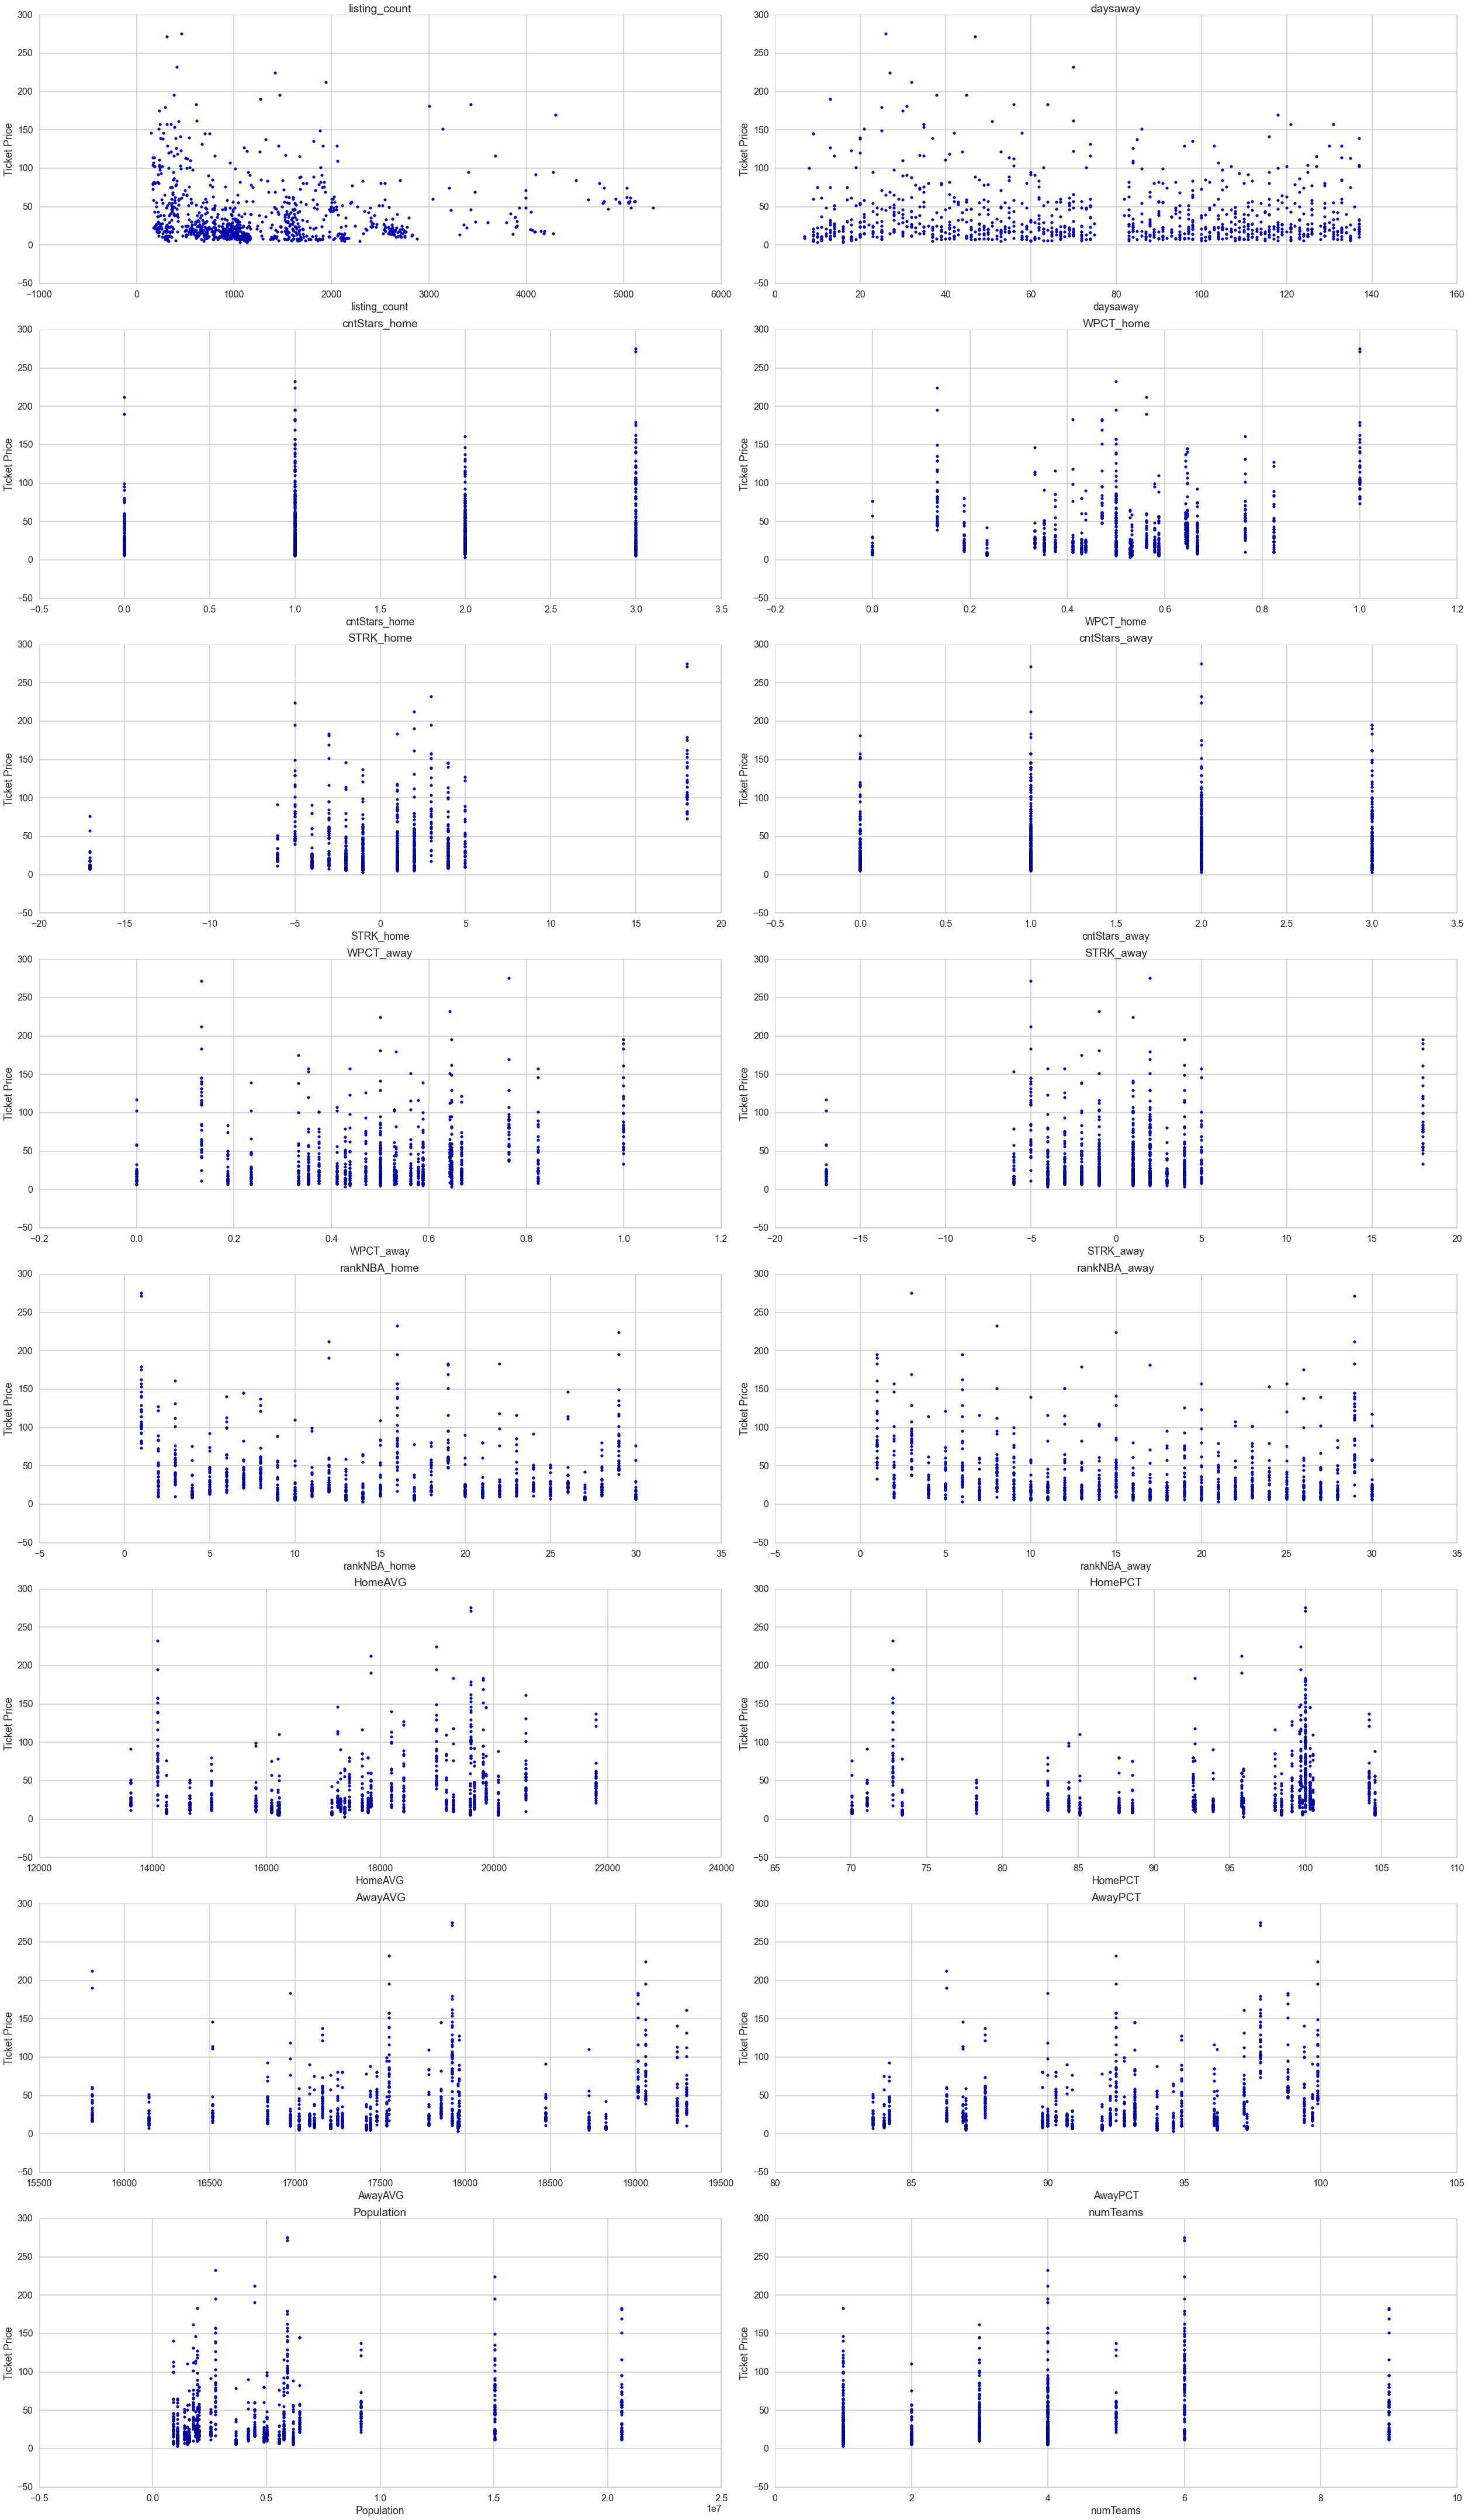

In [414]:
# examine the more continuous variables for transformations
continuousvariablesweek = ['listing_count',
 'daysaway',
 'cntStars_home',
 'WPCT_home',
 'STRK_home',
 'cntStars_away',
 'WPCT_away',
 'STRK_away',
 'rankNBA_home',
 'rankNBA_away',
 'HomeAVG',
 'HomePCT',
 'AwayAVG',
 'AwayPCT',
 'Population',
 'numTeams',
 'holiday']


fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(35, 60), tight_layout=True)
for ax, xvar in zip(axes.ravel(), continuousvariablesweek):
    ax.scatter(regdfweek[xvar], regdfweek["lowest_price_good_now"])
    ax.set_title(xvar)
    ax.set_xlabel(xvar)
    ax.set_ylabel('Ticket Price')


We see here that population and daysaway have somewhat non-linear relationships that might be improved by log transformations. We make these log transformations below and plot the untransformed and transformed data against min. ticket price:

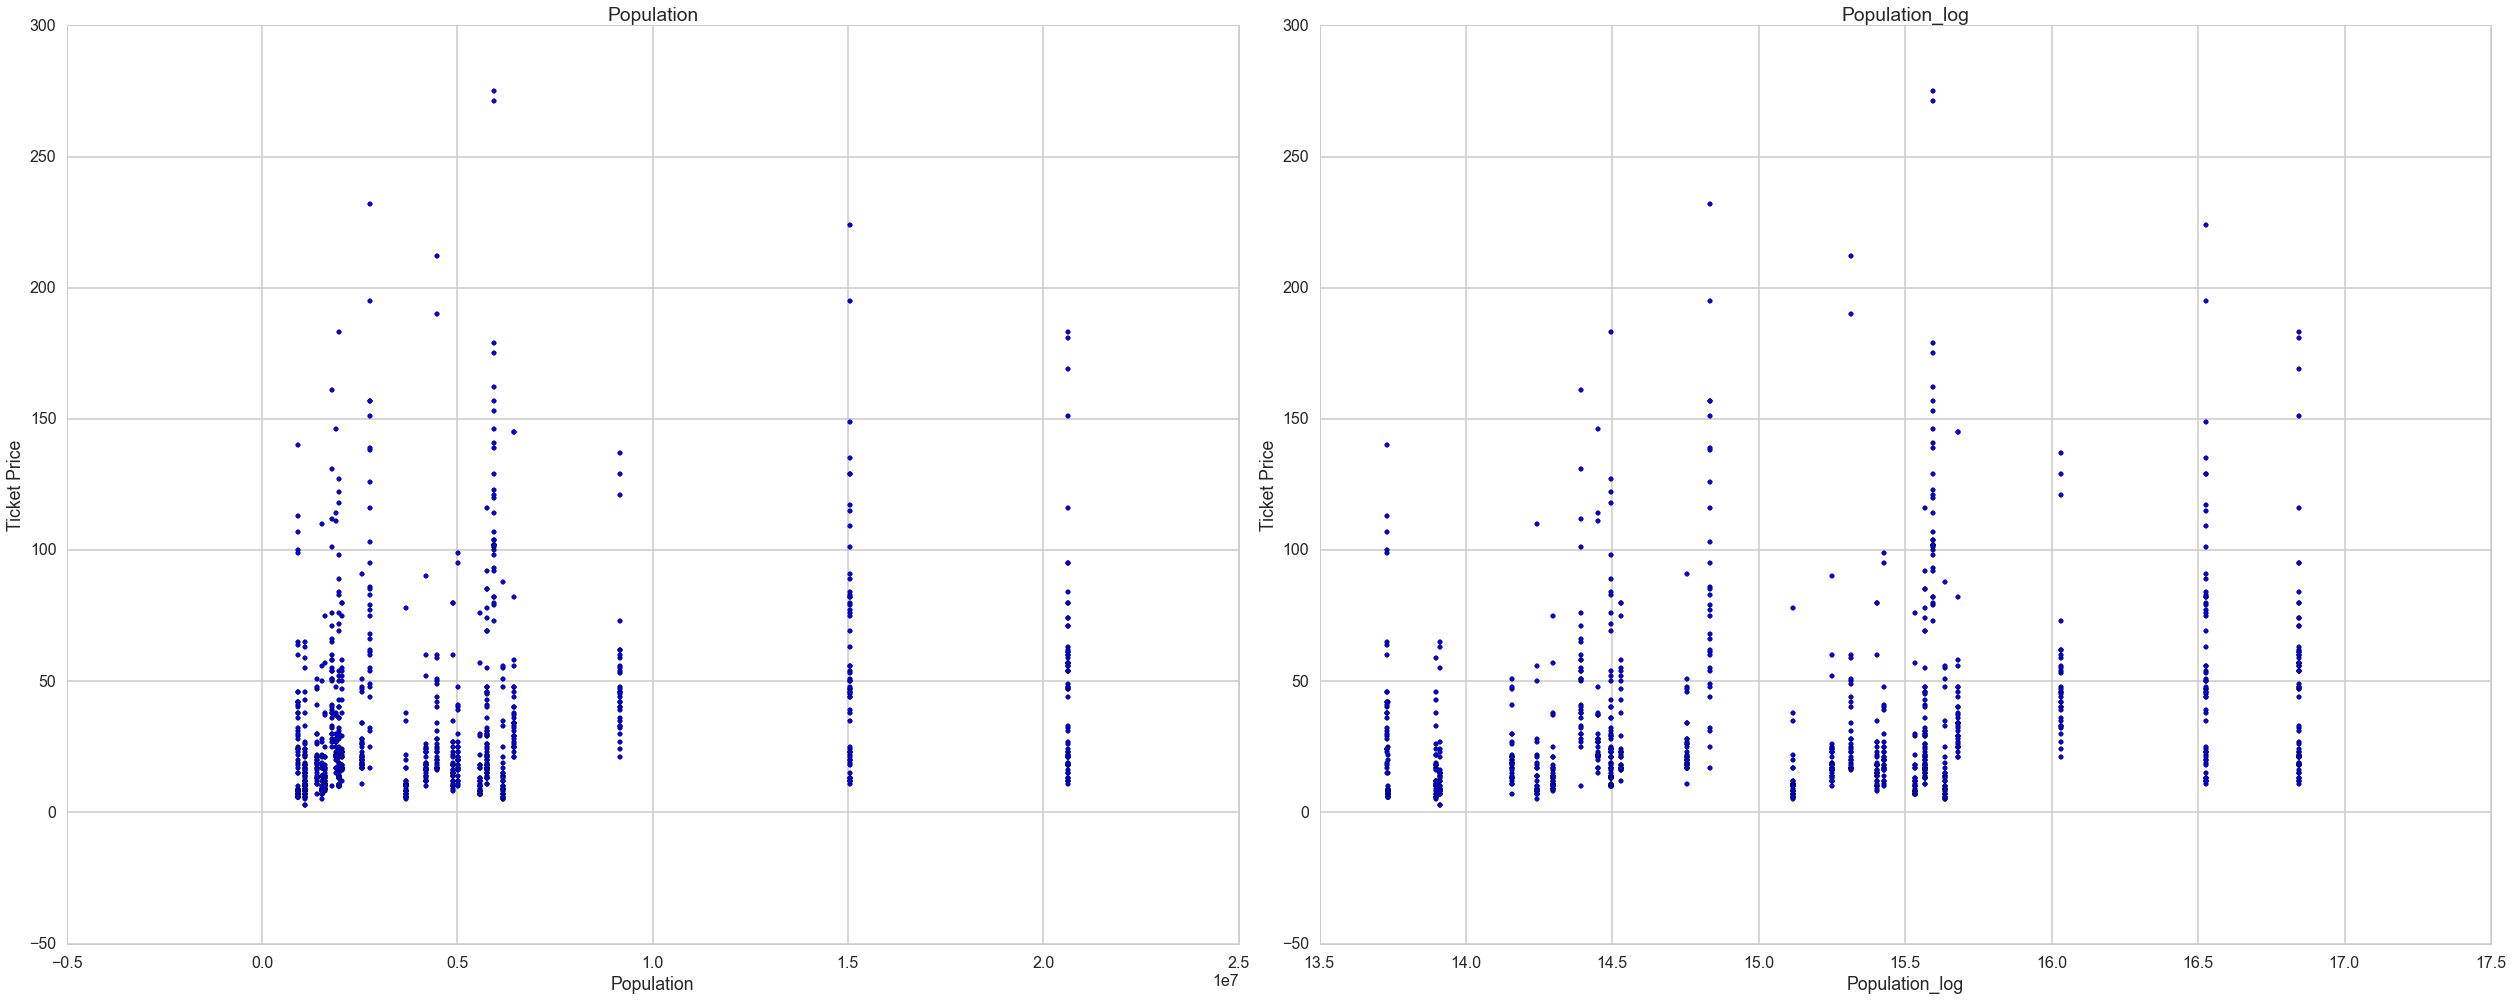

In [415]:
regdfweek["Population_log"] = np.log(regdfweek["Population"])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(35, 14), tight_layout=True)
for ax, xvar in zip(axes.ravel(), ["Population", "Population_log"]):
    ax.scatter(regdfweek[xvar], regdfweek["lowest_price_good_now"])
    ax.set_title(xvar)
    ax.set_xlabel(xvar)
    ax.set_ylabel('Ticket Price')

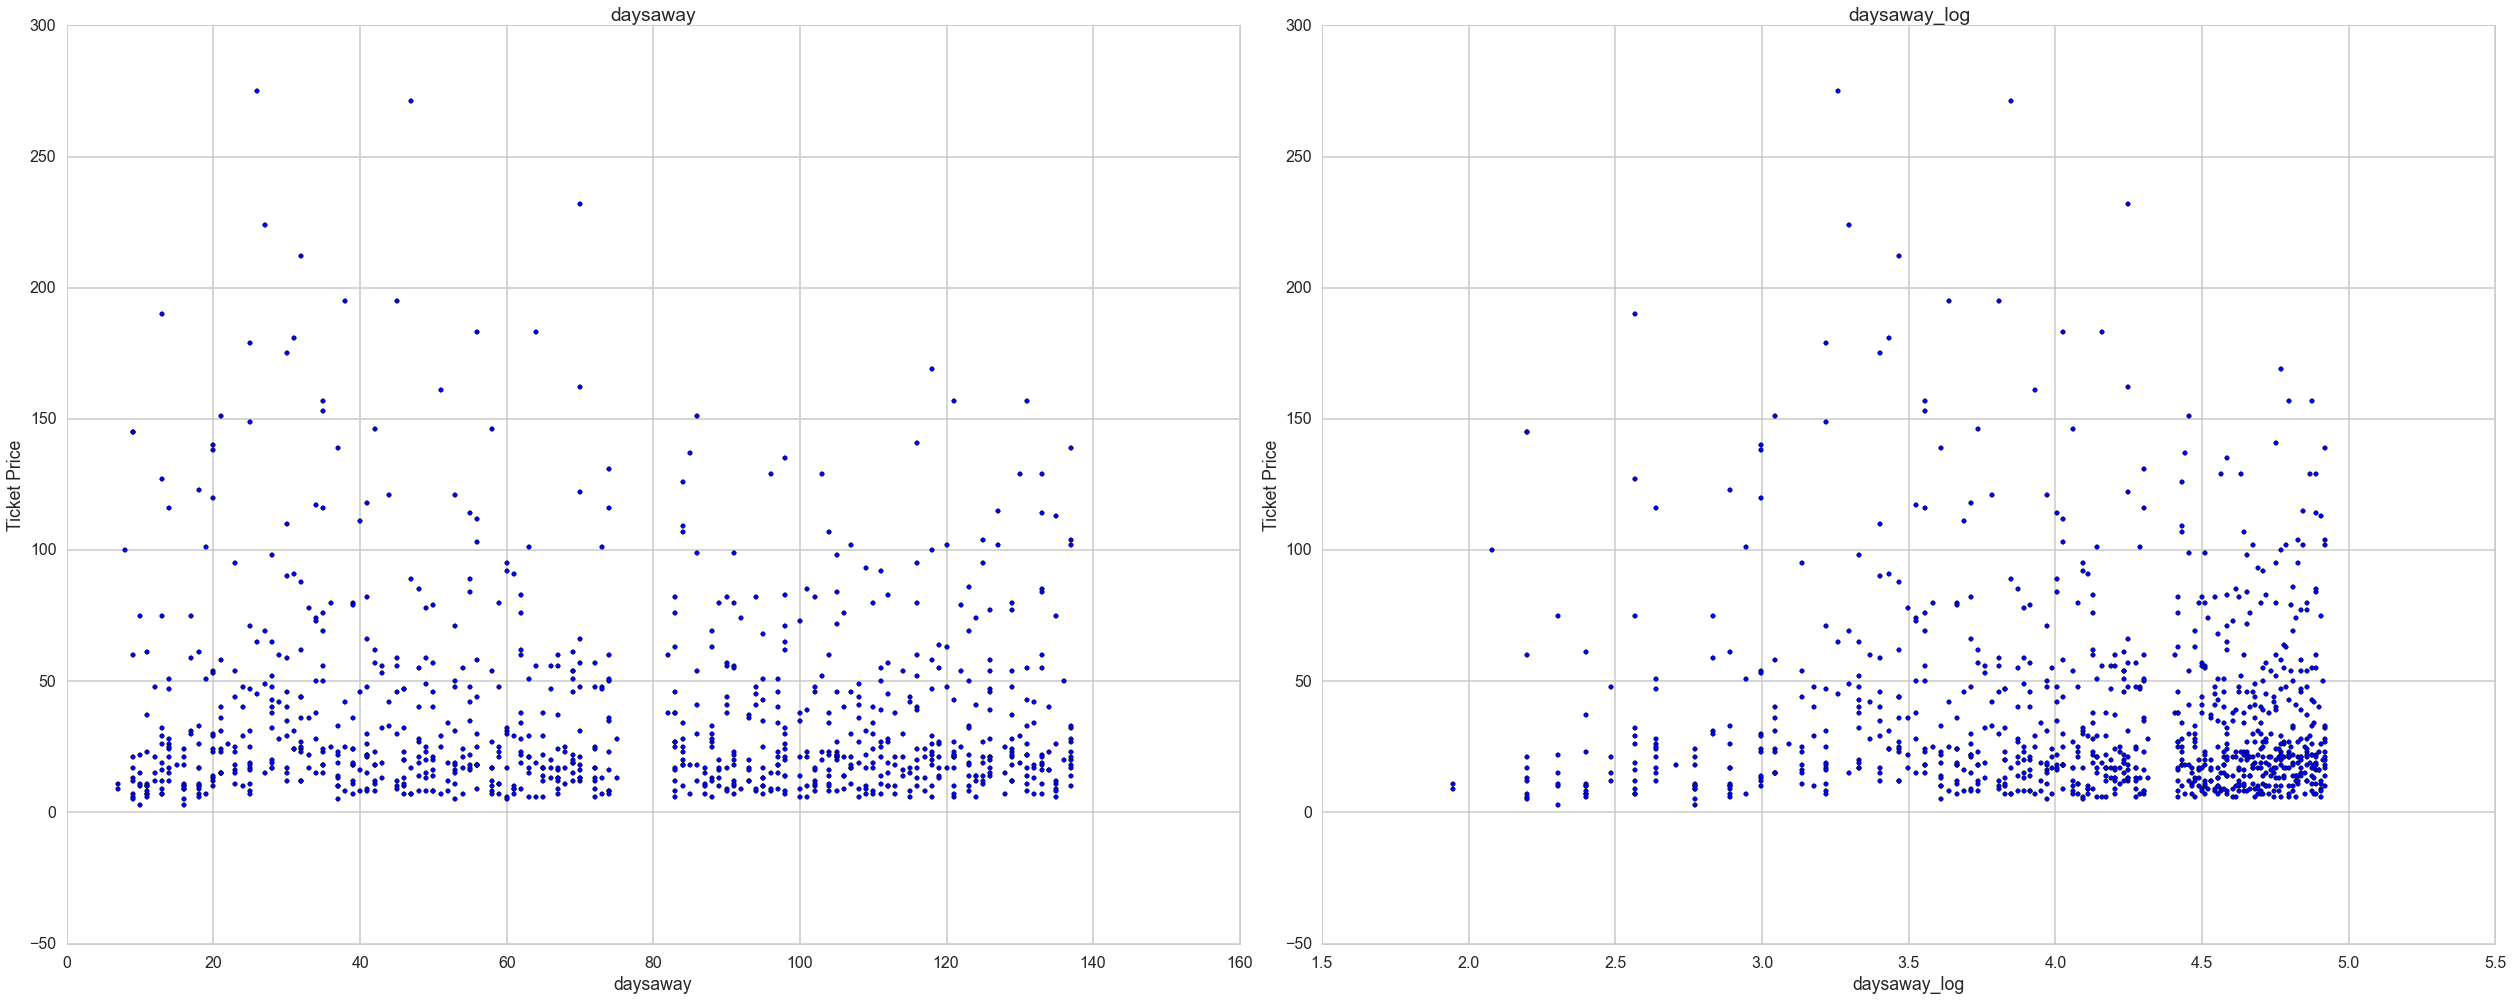

In [416]:
regdfweek['daysaway_log'] = np.log(regdfweek['daysaway'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(35, 14), tight_layout=True)
for ax, xvar in zip(axes.ravel(), ["daysaway", "daysaway_log"]):
    ax.scatter(regdfweek[xvar], regdfweek["lowest_price_good_now"])
    ax.set_title(xvar)
    ax.set_xlabel(xvar)
    ax.set_ylabel('Ticket Price')

We see significant improvement in the linearity of the relationship between population and ticket price and daysaway and ticket price when we log them.

## c. Define Model Formulas and Set Up DataFrame for Regression

***We define models according to three sets of predictors:***

- **Simple set: the relevant predictors without any potentially redundant information. Because the data is from a snapshot in time, team rankings and location-related predictors are exactly associated with a single team. We omitted team indicators to eliminate potential redundancies.**


- **Intuitive set: the simple set plus the potentially redundant team indicator variables. We call this "intuitive" because it encapsulates all intuitively useful predictors.**


- **All set: this is the intuitive set plus nearly all other two-way combinations for interaction terms. We merely excluded interactions with the weekdays and away teams, as we felt the number of predictors these would add would be too substantial for the potential benefit. Having used interaction terms in other courses substantially, we felt that this would be an interesting way to test the limits of the "predictor-selecting" models we explored in CS 109 (we used Ridge, Lasso, and Elastic Nets - more on this later). Including a ton of potentially relevant information in these models might cause them to find the "gems" among the all of the "junk" and produce excellent predictions.**

***We print the model statements for each of these three sets below.***

In [444]:
# define the sets of variables for 3 models of different layers of complexity

xvarssimpleweek = ['listing_count',
 'daysaway_log',
 'cntStars_home',
 'WPCT_home',
 'STRK_home',            
 'STRK_home',                        
 'cntStars_away',
 'WPCT_away',
 'STRK_away',            
 'STRK_away',                        
 'rankNBA_home',
 'rankNBA_away',           
 'HomeAVG',
 'HomePCT',
 'AwayAVG',
 'AwayPCT',
 'Population_log',
 'numTeams',
 'holiday'
  ]

xvarsintuitiveweek = xvarssimpleweek

# make interaction terms for third set
listVarweek=['listing_count',
 'daysaway_log',
 'cntStars_home',
 'WPCT_home',                     
 'cntStars_away',
 'WPCT_away',                            
 'rankNBA_home',
 'rankNBA_away',            
 'HomeAVG',
 'HomePCT',
 'AwayAVG',
 'AwayPCT',
 'Population_log',
 'numTeams',
 'holiday']
listInteractweek=[]
for num in range(len(listVarweek)):
    for num1 in range(num,len(listVarweek)):
        if num != num1:
            name = listVarweek[num]+':'+listVarweek[num1]
            if name not in xvarsintuitiveweek:
                listInteractweek.append(name)
xvarsallweek = xvarsintuitiveweek + listInteractweek

Add teams and binaries for teams:

In [418]:
# # Add home team and home team binaries terms:

hometeamsweek = list(np.unique(regdfweek["home_team"]))

# drop the first team to avoid perfect collinearity
del hometeamsweek[0]
regdfweek = regdfweek.reset_index()

hometeamslistweek = []
justteamshomeweek = []

count = 1
for team in hometeamsweek:
    temp = np.zeros(len(regdfweek["home_team"]))
    for i in range(0,len(temp)):
        if regdfweek.loc[i,"home_team"] == team:
            temp[i] = 1
    name = team.replace(" ","") + "_home"
    regdfweek[name] = temp
    justteamshomeweek.append(name)
    name = name + ":daysaway_log"
    hometeamslistweek.append(name)
    count = count + 1

# add to variable lists
xvarsallweek = xvarsallweek + hometeamslistweek + justteamshomeweek
xvarsintuitiveweek = xvarsintuitiveweek + justteamshomeweek
xvarssimpleweek = xvarssimpleweek

# # Add away team and away team interaction terms:
awayteamsweek = list(np.unique(regdfweek["away_team"]))

# drop the first team to avoid perfect collinearity
del awayteamsweek[0]

awayteamslistweek = []
justteamsawayweek = []

count = 1
for team in awayteamsweek:
    temp = np.zeros(len(regdfweek["away_team"]))
    for i in range(0,len(temp)):
        if regdfweek.loc[i,"away_team"] == team:
            temp[i] = 1
    name = team.replace(" ","") + "_away"
    regdfweek[name] = temp
    justteamsawayweek.append(name)
    name = name + ":daysaway_log"
    awayteamslistweek.append(name)
    count = count + 1

# add to variable lists
xvarsallweek = xvarsallweek + justteamsawayweek
xvarsintuitiveweek = xvarsintuitiveweek + justteamsawayweek
xvarssimpleweek = xvarssimpleweek


# # sources: http://stackoverflow.com/questions/8270092/python-remove-all-whitespace-in-a-string

Add binaries for weekdays:

In [419]:
# # Add weekday and weekday interaction terms:
weekdaysweek = list(np.unique(regdfweek["weekday"]))
# drop the first venue
del weekdaysweek[0]
weekdaylistweek = []


count = 1
for weekday in weekdaysweek:
    temp = np.zeros(len(regdfweek["weekday"]))
    for i in range(0,len(temp)):
        if regdfweek.loc[i,"weekday"] == weekday:
            temp[i] = 1
    name = weekday
    regdfweek[name] = temp
    weekdaylistweek.append(name)
    count = count + 1

# add to variable lists
xvarsallweek = xvarsallweek + weekdaylistweek
xvarsintuitiveweek = xvarsintuitiveweek + weekdaylistweek
xvarssimpleweek = xvarssimpleweek + weekdaylistweek

Add today's price:

In [420]:
# Add today's price to all variable lists
xvarssimpleweek.append("lowest_price_good_ago")
xvarsintuitiveweek.append("lowest_price_good_ago")
xvarsallweek.append("lowest_price_good_ago")

Use these lists of variables to create three model formulas and print those formulas:

In [421]:
# simple model
formulasimpleweek = str("lowest_price_good_now ~ ") + xvarssimpleweek[0]
count = 0
for xvar in xvarssimpleweek:
    if count > 0:
        formulasimpleweek = formulasimpleweek + "+" + xvar
    count = count + 1

print formulasimpleweek

lowest_price_good_now ~ listing_count+daysaway_log+cntStars_home+WPCT_home+STRK_home+STRK_home+cntStars_away+WPCT_away+STRK_away+STRK_away+rankNBA_home+rankNBA_away+HomeAVG+HomePCT+AwayAVG+AwayPCT+Population_log+numTeams+holiday+Monday+Saturday+Sunday+Thursday+Tuesday+Wednesday+lowest_price_good_ago


In [422]:
# intuitive model
formulaintuitiveweek = str("lowest_price_good_now ~ ") + xvarsintuitiveweek[0]
count = 0
for xvar in xvarsintuitiveweek:
    if count > 0:
        formulaintuitiveweek = formulaintuitiveweek + "+" + xvar
    count = count + 1

print formulaintuitiveweek

lowest_price_good_now ~ listing_count+daysaway_log+cntStars_home+WPCT_home+STRK_home+STRK_home+cntStars_away+WPCT_away+STRK_away+STRK_away+rankNBA_home+rankNBA_away+HomeAVG+HomePCT+AwayAVG+AwayPCT+Population_log+numTeams+holiday+BostonCeltics_home+BrooklynNets_home+CharlotteHornets_home+ChicagoBulls_home+ClevelandCavaliers_home+DallasMavericks_home+DenverNuggets_home+DetroitPistons_home+GoldenStateWarriors_home+HoustonRockets_home+IndianaPacers_home+LosAngelesClippers_home+LosAngelesLakers_home+MemphisGrizzlies_home+MiamiHeat_home+MilwaukeeBucks_home+MinnesotaTimberwolves_home+NewOrleansPelicans_home+NewYorkKnicks_home+OklahomaCityThunder_home+OrlandoMagic_home+Philadelphia76ers_home+PhoenixSuns_home+PortlandTrailBlazers_home+SacramentoKings_home+SanAntonioSpurs_home+TorontoRaptors_home+UtahJazz_home+WashingtonWizards_home+BostonCeltics_away+BrooklynNets_away+CharlotteHornets_away+ChicagoBulls_away+ClevelandCavaliers_away+DallasMavericks_away+DenverNuggets_away+DetroitPistons_away+Gold

In [423]:
# complex model
formulaallweek = str("lowest_price_good_now ~ ") + xvarsallweek[0]
count = 0
for xvar in xvarsallweek:
    if count > 0:
        formulaallweek = formulaallweek + "+" + xvar
    count = count + 1

print formulaallweek

lowest_price_good_now ~ listing_count+daysaway_log+cntStars_home+WPCT_home+STRK_home+STRK_home+cntStars_away+WPCT_away+STRK_away+STRK_away+rankNBA_home+rankNBA_away+HomeAVG+HomePCT+AwayAVG+AwayPCT+Population_log+numTeams+holiday+listing_count:daysaway_log+listing_count:cntStars_home+listing_count:WPCT_home+listing_count:cntStars_away+listing_count:WPCT_away+listing_count:rankNBA_home+listing_count:rankNBA_away+listing_count:HomeAVG+listing_count:HomePCT+listing_count:AwayAVG+listing_count:AwayPCT+listing_count:Population_log+listing_count:numTeams+listing_count:holiday+daysaway_log:cntStars_home+daysaway_log:WPCT_home+daysaway_log:cntStars_away+daysaway_log:WPCT_away+daysaway_log:rankNBA_home+daysaway_log:rankNBA_away+daysaway_log:HomeAVG+daysaway_log:HomePCT+daysaway_log:AwayAVG+daysaway_log:AwayPCT+daysaway_log:Population_log+daysaway_log:numTeams+daysaway_log:holiday+cntStars_home:WPCT_home+cntStars_home:cntStars_away+cntStars_home:WPCT_away+cntStars_home:rankNBA_home+cntStars_home:

Create data columns in the dataframe for the interaction terms:

In [424]:
# make interaction terms
for xvar in xvarsallweek:
    if xvar.find(":") != -1:
        var1,var2 = xvar.split(":")
        temp = regdfweek[var1]*regdfweek[var2]
        regdfweek[xvar] = temp

##d. Sample the Games and Run a Cross-Validation

***We ran the three sets of predictors on the following four models, to produce a total of 12 fit models.***

- **OLS Regression: this is the simplest, go-to model, and we expect it to perform worse than the others, which might filter out unnecessary data well.**


- **Ridge Regression: we used this because it ought to set the coefficients of less valuable predictors to near-zero values, which could produce excellent predictions given a large number of predictors.**


- **Lasso Regression: we used this because it ought to set the coefficients of less valuable predictors to zero values, which could produce excellent predictions given a large number of predictors.**


- **Elastic Net: we used this for similar reasons to the above.**

***Again, we trained and validated each of these on the following three predictor sets:***

- **Simple set**

- **Intuitive set**

- **All set**

***The model statements for these three predictors sets are printed above.***

***Instead of using k-fold cross-validations as in lecture, we split the data into testing and other data and then sampled randomly from that other data to produce training and validation sets. We did this because, given our large set of predictors and limited data, we wanted to ensure a large amount of data for fitting and a large amount of data for testing the models. Random sampling should avoid biases in this method. In the end, it allowed us to validate on a "larger" set of data; by doing 30 samples of 80 validation datapoints, we were able to validate on a total of 2400 points, far more than our dataset of roughly 800 datapoints that would be available in k-fold validation.***

Sample the games and store the samples so that the results are reproducible when you rerun the code:

In [94]:

######## Rerunning will overwrite reproducible results

# # sample by game ID number to avoid any indexing issues
# # store samples (like choosing a seed)


# uniqueids = regdfweek.id
# traininglength = 628
# testinglength = 80
# validatelength = 80

# testidsweek = np.random.choice(a = uniqueids, size = testinglength, replace = False)
# remainingidsweek = list([x for x in uniqueids if x not in testidsweek])

# trainidsdfweek = pd.DataFrame()
# testidsweekdf = pd.DataFrame()
# remainingidsweekdf = pd.DataFrame()
# for i in range(30):
#     trainidsdfweek[i] = np.random.choice(a = remainingidsweek, size = traininglength, replace = False)
# testidsweekdf[0] = testidsweek
# remainingidsweekdf[0] = remainingidsweek

# trainidsdfweek.to_csv("trainidsdfweek.csv")
# testidsweekdf.to_csv("testidsweekdf.csv")
# remainingidsweekdf.to_csv("remainingidsweekdf.csv")



print "complete"

Execute the cross validation, storing RMSE (Euclidean Distance) and MAD (Manhattan Distance) as prediction accuracy metrics:

In [98]:
%%time

trainidsdfweek = pd.DataFrame.from_csv("trainidsdfweek.csv")
reaminingidsweek = pd.DataFrame.from_csv("remainingidsweekdf.csv")
reaminingidsweek = list(reaminingidsweek["0"])
uniqueidsweek = np.unique(regdfweek.id)

# Stats for the Simple Model
olsmsessimpleweek = []
olsmadssimpleweek = []
ridgemsessimpleweek = []
ridgemadssimpleweek = []
lassomsessimpleweek = []
lassomadssimpleweek = []
enetmsessimpleweek = []
enetmadssimpleweek = []

# Stats for the Intuitive Model
olsmsesintuitiveweek = []
olsmadsintuitiveweek = []
ridgemsesintuitiveweek = []
ridgemadsintuitiveweek = []
lassomsesintuitiveweek = []
lassomadsintuitiveweek = []
enetmsesintuitiveweek = []
enetmadsintuitiveweek = []

# Stats for the Full Model
olsmsesallweek = []
olsmadsallweek = []
ridgemsesallweek = []
ridgemadsallweek = []
lassomsesallweek = []
lassomadsallweek = []
enetmsesallweek = []
enetmadsallweek = []


# Cross-Validate
for i in trainidsdfweek.columns.values:
    trainids = trainidsdfweek[i]
    validationids = set(remainingidsweek) - set(trainids)
    
    traindf = regdfweek.loc[regdfweek["id"].isin(trainids)]
    validatedf = regdfweek.loc[regdfweek["id"].isin(validationids)]
    
    # make simple model x and y dataframes
    forfitsimple = pd.DataFrame(traindf.lowest_price_good_now)
    forpredsimple = pd.DataFrame(validatedf.lowest_price_good_now)
    for xvar in xvarssimpleweek:
        forpredsimple[xvar] = validatedf[xvar]
        forfitsimple[xvar] = traindf[xvar]
    ytrainsimple,xtrainsimple = patsy.dmatrices(formulasimpleweek, data=forfitsimple)
    yvalidatesimple,xvalidatesimple = patsy.dmatrices(formulasimpleweek, data=forpredsimple)

    
    # make intuitive model x and y dataframes
    forfitintuitive = pd.DataFrame(traindf.lowest_price_good_now)
    forpredintuitive = pd.DataFrame(validatedf.lowest_price_good_now)
    for xvar in xvarsintuitiveweek:
        forpredintuitive[xvar] = validatedf[xvar]
        forfitintuitive[xvar] = traindf[xvar]
    ytrainintuitive,xtrainintuitive = patsy.dmatrices(formulaintuitiveweek, data=forfitintuitive)
    yvalidateintuitive,xvalidateintuitive = patsy.dmatrices(formulaintuitiveweek, data=forpredintuitive)
    
    
    
    # make full model x and y dataframes    
    forfitall = pd.DataFrame(traindf.lowest_price_good_now)
    forpredall = pd.DataFrame(validatedf.lowest_price_good_now)
    for xvar in xvarsallweek:
        forpredall[xvar] = validatedf[xvar]
        forfitall[xvar] = traindf[xvar]
    ytrainall,xtrainall = patsy.dmatrices(formulaallweek, data=forfitall)
    yvalidateall,xvalidateall = patsy.dmatrices(formulaallweek, data=forpredall)
    
    
    
    
# Simple Models    

    # linear
    fit = ols(formulasimpleweek, data = forfitsimple).fit()
    preds = fit.predict(forpredsimple)
    prederrors = []
    count = 0
    for act in yvalidatesimple:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    olsmsessimpleweek.append(np.mean(squarelist(prederrors)))
    olsmadssimpleweek.append(np.mean(abslist(prederrors))) 
    
    # ridge
    fitridge = cv_optimize_ridge(xtrainsimple, ytrainsimple, n_folds=8)
    alpharidge = fitridge.best_params_['alpha']
    clfridge = Ridge(alpha=alpharidge).fit(xtrainsimple,ytrainsimple)
    preds = clfridge.predict(xvalidatesimple)
    prederrors = []
    count = 0
    for act in yvalidatesimple:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    ridgemsessimpleweek.append(np.mean(squarelist(prederrors)))
    ridgemadssimpleweek.append(np.mean(abslist(prederrors))) 
    
    # lasso
    fitlasso = cv_optimize_lasso(xtrainsimple, ytrainsimple, n_folds=8)
    alphalasso = fitlasso.best_params_['alpha']
    clflasso = Lasso(alpha=alphalasso).fit(xtrainsimple,ytrainsimple)
    preds = clflasso.predict(xvalidatesimple)
    prederrors = []
    count = 0
    for act in yvalidatesimple:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    lassomsessimpleweek.append(np.mean(squarelist(prederrors)))
    lassomadssimpleweek.append(np.mean(abslist(prederrors)))  

    # enet
    fitenet = cv_optimize_enet(xtrainsimple, forfitsimple["lowest_price_good_now"], n_folds=8)
    alphaenet = fitenet.best_params_['alpha']
    clfenet = ElasticNet(alpha=alphaenet).fit(xtrainsimple,forfitsimple["lowest_price_good_now"])
    preds = clfenet.predict(xvalidatesimple)
    prederrors = []
    count = 0
    for act in yvalidatesimple:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    enetmsessimpleweek.append(np.mean(squarelist(prederrors)))
    enetmadssimpleweek.append(np.mean(abslist(prederrors)))       
    
    
    
# Models with Seemingly Reasonable Interactions by Intuition

    # linear
    fit = ols(formulaintuitiveweek, data = forfitintuitive).fit()
    preds = fit.predict(forpredintuitive)    
    prederrors = []
    count = 0
    for act in yvalidateintuitive:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    olsmsesintuitiveweek.append(np.mean(squarelist(prederrors)))
    olsmadsintuitiveweek.append(np.mean(abslist(prederrors))) 
        
    
    # ridge
    fitridge = cv_optimize_ridge(xtrainintuitive, ytrainintuitive, n_folds=8)
    alpharidge = fitridge.best_params_['alpha']
    clfridge = Ridge(alpha=alpharidge).fit(xtrainintuitive,ytrainintuitive)
    preds = clfridge.predict(xvalidateintuitive)
    prederrors = []
    count = 0
    for act in yvalidateintuitive:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    ridgemsesintuitiveweek.append(np.mean(squarelist(prederrors)))
    ridgemadsintuitiveweek.append(np.mean(abslist(prederrors))) 
    
    
    # lasso
    fitlasso = cv_optimize_lasso(xtrainintuitive, ytrainintuitive, n_folds=8)
    alphalasso = fitlasso.best_params_['alpha']
    clflasso = Lasso(alpha=alphalasso).fit(xtrainintuitive,ytrainintuitive)
    preds = clflasso.predict(xvalidateintuitive)
    prederrors = []
    count = 0
    for act in yvalidateintuitive:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    lassomsesintuitiveweek.append(np.mean(squarelist(prederrors)))
    lassomadsintuitiveweek.append(np.mean(abslist(prederrors))) 

    # enet
    fitenet = cv_optimize_enet(xtrainintuitive, forfitintuitive["lowest_price_good_now"], n_folds=8)
    alphaenet = fitenet.best_params_['alpha']
    clfenet = ElasticNet(alpha=alphaenet).fit(xtrainintuitive,forfitintuitive["lowest_price_good_now"])
    preds = clfenet.predict(xvalidateintuitive)
    prederrors = []
    count = 0
    for act in yvalidateintuitive:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    enetmsesintuitiveweek.append(np.mean(squarelist(prederrors)))
    enetmadsintuitiveweek.append(np.mean(abslist(prederrors)))
    
    
# Models with Nearly All Interaction Terms
    # linear
    fit = ols(formulaallweek, data = forfitall).fit()
    preds = fit.predict(forpredall)    
    prederrors = []
    count = 0
    for act in yvalidateall:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    olsmsesallweek.append(np.mean(squarelist(prederrors)))
    olsmadsallweek.append(np.mean(abslist(prederrors))) 
        
    
    # ridge
    fitridge = cv_optimize_ridge(xtrainall, ytrainall, n_folds=8)
    alpharidge = fitridge.best_params_['alpha']
    clfridge = Ridge(alpha=alpharidge).fit(xtrainall,ytrainall)
    preds = clfridge.predict(xvalidateall)
    prederrors = []
    count = 0
    for act in yvalidateall:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    ridgemsesallweek.append(np.mean(squarelist(prederrors)))
    ridgemadsallweek.append(np.mean(abslist(prederrors))) 
    
    
    # lasso
    fitlasso = cv_optimize_lasso(xtrainall, ytrainall, n_folds=8)
    alphalasso = fitlasso.best_params_['alpha']
    clflasso = Lasso(alpha=alphalasso).fit(xtrainall,ytrainall)
    preds = clflasso.predict(xvalidateall)
    prederrors = []
    count = 0
    for act in yvalidateall:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    lassomsesallweek.append(np.mean(squarelist(prederrors)))
    lassomadsallweek.append(np.mean(abslist(prederrors))) 

    # enet
    fitenet = cv_optimize_enet(xtrainall, forfitall["lowest_price_good_now"], n_folds=8)
    alphaenet = fitenet.best_params_['alpha']
    clfenet = ElasticNet(alpha=alphaenet).fit(xtrainall,forfitall["lowest_price_good_now"])
    preds = clfenet.predict(xvalidateall)
    prederrors = []
    count = 0
    for act in yvalidateall:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    enetmsesallweek.append(np.mean(squarelist(prederrors)))
    enetmadsallweek.append(np.mean(abslist(prederrors)))
    
    

    
# sources: http://stackoverflow.com/questions/2104305/finding-elements-not-in-a-list, http://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas, http://statsmodels.sourceforge.net/0.6.0/examples/notebooks/generated/predict.html, http://stackoverflow.com/questions/20724919/pandas-dataframe-attributeerror-dataframe-object-has-no-attribute-design-inf

CPU times: user 21min 41s, sys: 12.3 s, total: 21min 54s
Wall time: 21min 52s


##e. Examine the Cross Validation Results

***Here, we view the results of the cross-validation to choose the model that predicts best. In terms of both MSE and MAD, the Lasso Model on the Intuitive Set of predictors has the predictions that are "closest" to next week's actual values.***


***Interestingly, our test of the limits of lasso, ridge, and elastic net showed that given too much "garbage", they were not able to sift out the "gems" in such a way as to predict better than a more intuitive model. That being said, even the intuitive model has a large number of predictors, and these are most certainly effective over OLS in choosing the good ones, as seen by the prediction metrics below. The potentially redundant information on teams added in the Intuitive Set was handled very well by these models.***

Table for RMSEs:

In [99]:
Simple = [round(np.sqrt(np.mean(olsmsessimpleweek)),2), round(np.sqrt(np.mean(ridgemsessimpleweek)),2), round(np.sqrt(np.mean(lassomsessimpleweek)),2), round(np.sqrt(np.mean(enetmsessimpleweek)),2)]
Intuitive = [round(np.sqrt(np.mean(olsmsesintuitiveweek)),2), round(np.sqrt(np.mean(ridgemsesintuitiveweek)),2), round(np.sqrt(np.mean(lassomsesintuitiveweek)),2), round(np.sqrt(np.mean(enetmsesintuitiveweek)),2)]
All = [round(np.sqrt(np.mean(olsmsesallweek)),2), round(np.sqrt(np.mean(ridgemsesallweek)),2), round(np.sqrt(np.mean(lassomsesallweek)),2), round(np.sqrt(np.mean(enetmsesallweek)),2)]

MSEResultstableweek = pd.DataFrame()
MSEResultstableweek["Simple"] = Simple
MSEResultstableweek["Intuitive"] = Intuitive
MSEResultstableweek["All"] = All
MSEResultstableweek.index = ["OLS","Ridge","Lasso", "ElasticNet"]
print "Cross Validation Root Avg. MSE Next Week's Price:"
MSEResultstableweek

Cross Validation Root Avg. MSE Next Week's Price:


Simple  Intuitive    All
OLS          13.92      12.23  14.72
Ridge        13.99      12.18  13.22
Lasso        14.14      11.94  13.83
ElasticNet   14.13      12.12  13.82

Plot for RMSEs:

RMSE Results for Different Models of Next Week's Price:


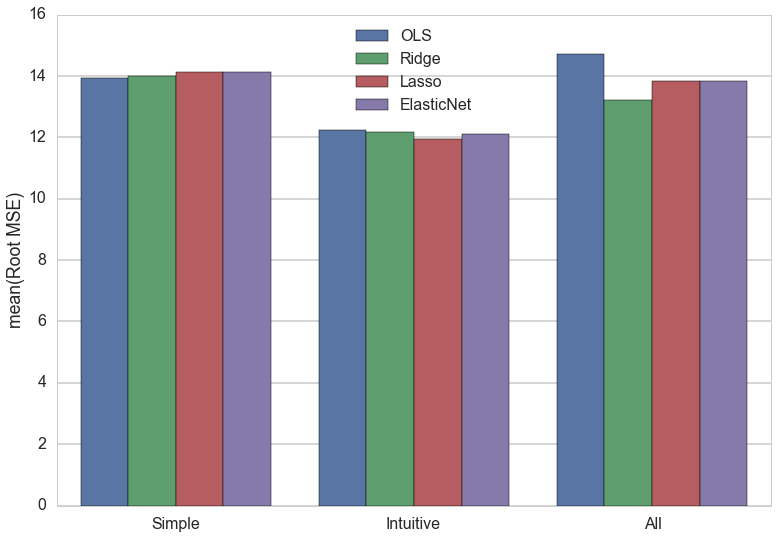

In [100]:
MSE = Simple + Intuitive + All
forplottableweek = pd.DataFrame()
forplottableweek["Root MSE"] = MSE
indices = [list(MSEResultstableweek.index) + list(MSEResultstableweek.index) + list(MSEResultstableweek.index)]
forplottableweek.index = indices
digits = ["Simple","Simple","Simple", "Simple"] + ["Intuitive","Intuitive","Intuitive","Intuitive"] + ["All","All","All", "All"]
forplottableweek["Digits"] = digits
print "RMSE Results for Different Models of Next Week's Price:"
sns.barplot(y = "Root MSE",x = digits, hue = forplottableweek.index.values, data = forplottableweek)

Table for MADs:

In [101]:
Simple = [round(np.mean(olsmadssimpleweek),2), round(np.mean(ridgemadssimpleweek),2), round(np.mean(lassomadssimpleweek),2), round(np.mean(enetmadssimpleweek),2)]
Intuitive = [round(np.mean(olsmadsintuitiveweek),2), round(np.mean(ridgemadsintuitiveweek),2), round(np.mean(lassomadsintuitiveweek),2), round(np.mean(enetmadsintuitiveweek),2)]
All = [round(np.mean(olsmadsallweek),2), round(np.mean(ridgemadsallweek),2), round(np.mean(lassomadsallweek),2), round(np.mean(enetmadsallweek),2)]

MADResultstableweek = pd.DataFrame()
MADResultstableweek["Simple"] = Simple
MADResultstableweek["Intuitive"] = Intuitive
MADResultstableweek["All"] = All
MADResultstableweek.index = ["OLS","Ridge","Lasso", "ElasticNet"]
print "Cross Validation Avg. MAD Next Week's Price:"
MADResultstableweek

Cross Validation Avg. MAD Next Week's Price:


Simple  Intuitive   All
OLS           7.27       6.10  7.79
Ridge         7.03       5.94  7.14
Lasso         6.70       5.50  7.22
ElasticNet    6.66       5.96  7.13

Plot for MADs:

MAD Results for Different Models of Next Week's Price:


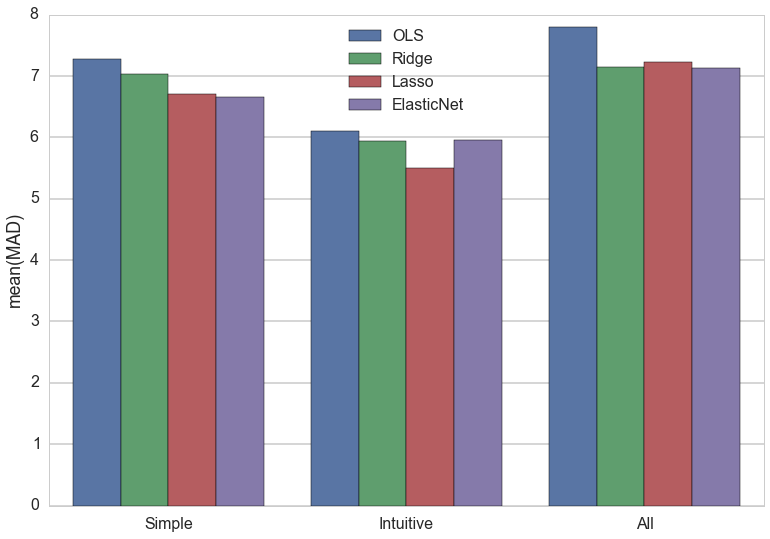

In [102]:
MAD = Simple + Intuitive + All
forplottableweek = pd.DataFrame()
forplottableweek["MAD"] = MAD
indices = [list(MADResultstableweek.index) + list(MADResultstableweek.index) + list(MADResultstableweek.index)]
forplottableweek.index = indices
digits = ["Simple","Simple","Simple", "Simple"] + ["Intuitive","Intuitive","Intuitive","Intuitive"] + ["All","All","All", "All"]
forplottableweek["Digits"] = digits
print "MAD Results for Different Models of Next Week's Price:"
sns.barplot(y = "MAD",x = digits, hue = forplottableweek.index.values, data = forplottableweek)

##f. Test the Best Model on the Test Set to Determine Unbiased Prediction Accuracy

***The best model at predicting, the Lasso on the Intuitive Set, produced a final MAD of 3.80, meaning that its predictions a week ahead are typically off by 3.80 dollars. We compare this to the baseline of predicting next week's price using today's price. The baseline has an MAD of 3.94, which is worse than our predictive model. There is also a substantial difference in RMSE, which tends to punish large errors more because of its use of the square function.***

Examine RMSE and MAD:

In [375]:
# make full model x and y dataframes

# data frame with just testids
testidsweek = list(pd.DataFrame.from_csv("testidsweekdf.csv")["0"])
dfforaccuracy = regdfweek.loc[regdfweek["id"].isin(testidsweek)]
dfforfitaccuracy = regdfweek.loc[~regdfweek["id"].isin(testidsweek)]

# create design matrices:
foraccuracyfit = pd.DataFrame(dfforfitaccuracy.lowest_price_good_now)
foraccuracypred = pd.DataFrame(dfforaccuracy.lowest_price_good_now)
for xvar in xvarsintuitiveweek:
    foraccuracyfit[xvar] = dfforfitaccuracy[xvar]
    foraccuracypred[xvar] = dfforaccuracy[xvar]
ydataaccuracy,xdataaccuracy = patsy.dmatrices(formulaintuitiveweek, data=foraccuracyfit)
ydataaccuracypred,xdataaccuracypred = patsy.dmatrices(formulaintuitiveweek, data=foraccuracypred)

# fit lasso
fitlassoaccuracy = cv_optimize_lasso(xdataaccuracy, ydataaccuracy, n_folds=8)
alphalasso = fitlassoaccuracy.best_params_['alpha']
clflassofullweek = Lasso(alpha=alphalasso).fit(xdataaccuracy,ydataaccuracy)

# predictions
predweek = clflassofullweek.predict(xdataaccuracypred)

# errors
lastweek = dfforaccuracy.lowest_price_good_ago.values
prederrors = []
prederrorsweek = prederrors
baselineerrors = []
count = 0
for act in dfforaccuracy.lowest_price_good_now.values:
    prederrors.append(float(predweek[count] - act))
    baselineerrors.append(float(lastweek[count] - act))
    count = count + 1
    
# stats on test set
statstableweek = pd.DataFrame()
statstableweek["One Week Lasso Accuracy"] = [round(np.sqrt(np.mean(squarelist(prederrors))),2), round(np.mean(abslist(prederrors)),2)]
statstableweek["Baseline Accuracy"] = [round(np.sqrt(np.mean(squarelist(baselineerrors))),2), round(np.mean(abslist(baselineerrors)),2)]
statstableweek.index = ["RMSE","MAD"]
statstableweek

# sources: http://stackoverflow.com/questions/19960077/how-to-implement-in-and-not-in-for-pandas-dataframe, http://stackoverflow.com/questions/30323439/raising-elements-of-a-list-to-a-power

One Week Lasso Accuracy  Baseline Accuracy
RMSE                     7.31              10.41
MAD                      3.80               3.94

View Predictions Relative to Baseline:

***We plot 14 randomly selected predictions agains the actual price and the baseline prediction of last week's price. We see very well suggestions of the success of our predictions here, for example in the Sacramento Kings vs. Phoenix Suns game and the Orlando Magic vs. Brooklyn Nets game. We see that, at least in this sample, our model tends to predict well for larger changes and tends to choose the correct direction of change in price, which is a very good results.***

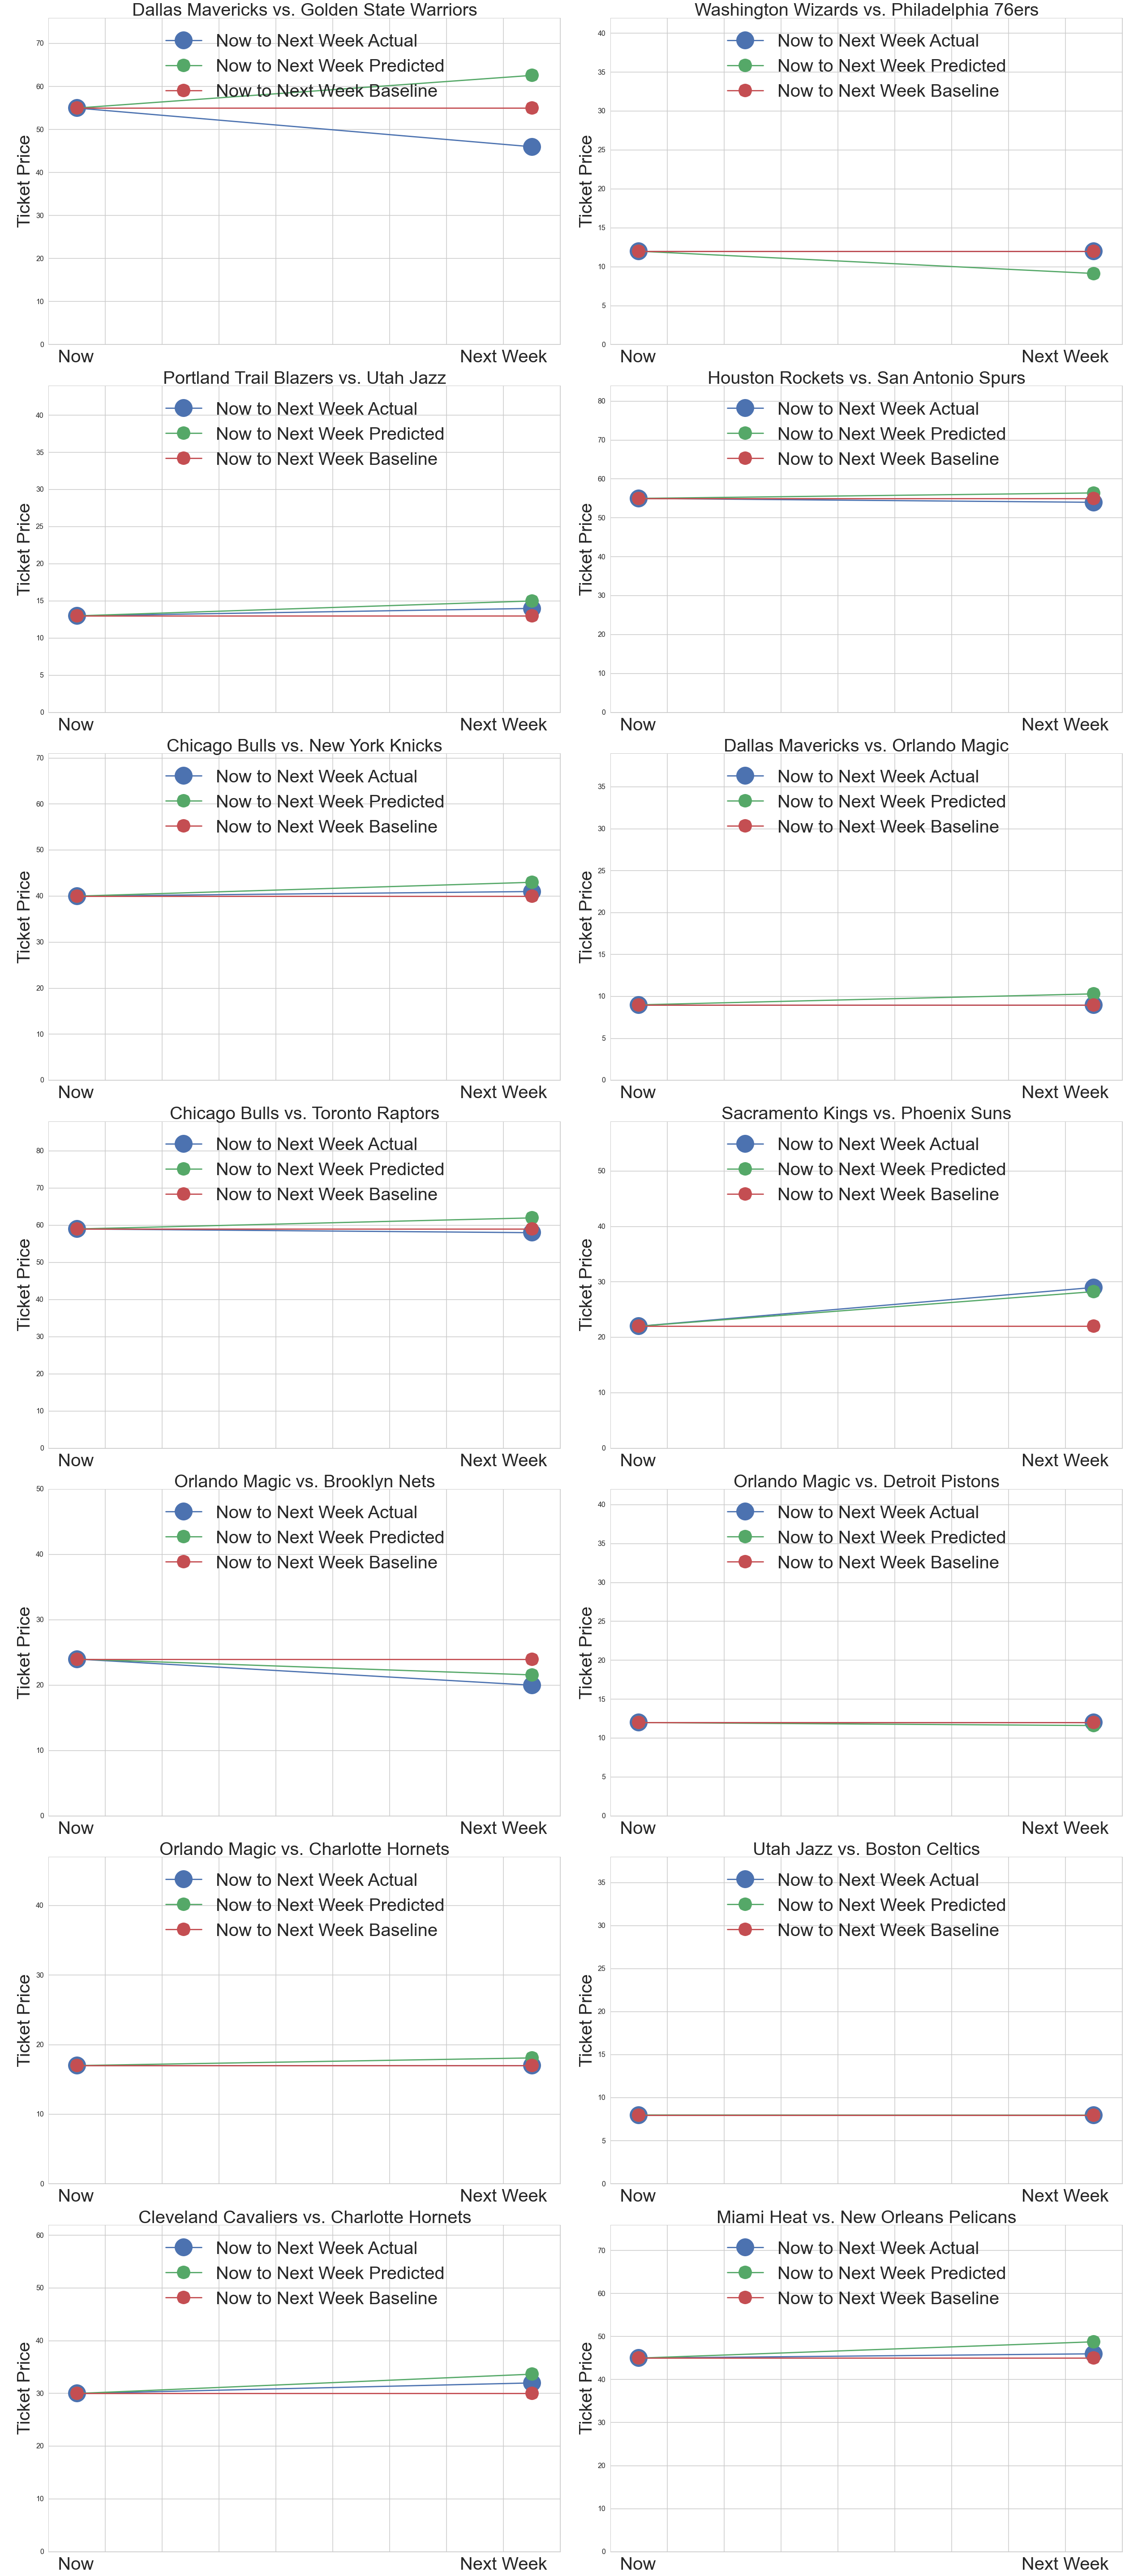

In [203]:
# data for plot function
actualnextweek = list(ydataaccuracypred)
actuallastweek = list(dfforaccuracy.lowest_price_good_ago)
data = dfforaccuracy#.drop("level_0", axis = 1)
predicted = predweek

plotpred(actualnextweek, actuallastweek, predicted, data)

View errors with respect to days away from game and home team rank:

***We plot the prediction errors against the number of days away the game is at the START of the prediction period. We see that we have large negative errors for games in the near future; we expect the minimum good deal price to be higher near game day than it truly is.***


***We also colored the points by home team rank (which, because we pulled the data at a single time, is associated with individual teams). We don't see any trends here, suggesting that there is no systematic error in prediction for any given team.***

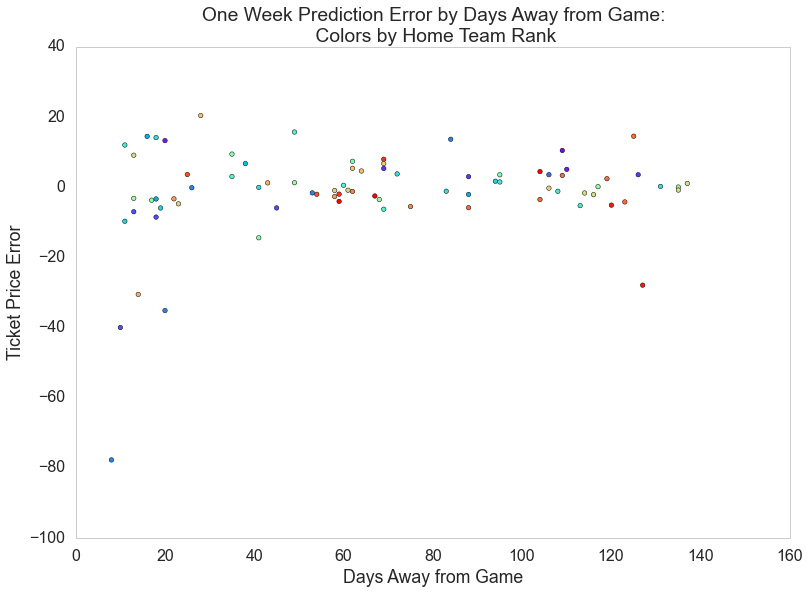

In [61]:
errorsplot(dfforaccuracy.daysaway,prederrorsweek,dfforaccuracy.rankNBA_home)

##g. Fit the Model on All Data to Examine Coefficients and Have a Model for Future Use

***We fit the model on all of the data. This gives us the model that we would use for prediction on future data. Also, it allows us to view the coefficients that are set and understand how the model works on all of the data.***

Fit the model and calculate the coefficients:

In [204]:
# make design matrices from all data   
forfitalldataintuitive = pd.DataFrame(regdfweek.lowest_price_good_now)
for xvar in xvarsintuitiveweek:
    forfitalldataintuitive[xvar] = regdfweek[xvar]
ydataintuitive,xdataintuitive = patsy.dmatrices(formulaintuitiveweek, data=forfitalldataintuitive)

# fit lasso
fitlasso = cv_optimize_lasso(xdataintuitive, ydataintuitive, n_folds=8)
alphaintuitive = fitridge.best_params_['alpha']
clfintuitivefullweek = Lasso(alpha=alphalasso).fit(xdataintuitive,ydataintuitive)

# make a table of all coefficients:
lassocoefstableweek = pd.DataFrame()
lassocoefstableweek["Predictor"] =  xdataintuitive.design_info.column_names
lassocoefstableweek["Coefficient"] = clflassofullweek.coef_

# Split the coefficients up for easier viewing:
# Daysaway coefficients
count = 0
daysindices = []
for x in xdataintuitive.design_info.column_names:
    if str(x).find("daysaway") != -1:
        daysindices.append(count)
    count = count + 1

dayscoefsweek = lassocoefstableweek.loc[daysindices,["Predictor","Coefficient"]]


# Home teams coefficients

hometeamindices = lassocoefstableweek.index[lassocoefstableweek["Predictor"].isin(justteamshomeweek) == 1]
hometeamcoefsweek = lassocoefstableweek.loc[hometeamindices,["Predictor","Coefficient"]]

# Away teams coefficients

awayteamindices = lassocoefstableweek.index[lassocoefstableweek["Predictor"].isin(justteamsawayweek) == 1]
awayteamcoefsweek = lassocoefstableweek.loc[awayteamindices,["Predictor","Coefficient"]]


# Days of week coefficients

count = 0
weekdaysindices = []
for x in xdataintuitive.design_info.column_names:
    if x in weekdaysweek:
        weekdaysindices.append(count)
    count = count + 1
daysofweekcoefsweek = lassocoefstableweek.loc[weekdaysindices,["Predictor","Coefficient"]]


# All other coefficients

taken = []
for i in daysindices:
    taken.append(i)
for i in hometeamindices:
    taken.append(i)
for i in awayteamindices:
    taken.append(i)    
for i in weekdaysindices:
    taken.append(i)
temp = range(0,len(clflassofullweek.coef_))
restofcoefs = [x for x in temp if x not in taken]

restcoefsweek = lassocoefstableweek.loc[restofcoefs,["Predictor","Coefficient"]]


# sources: http://stackoverflow.com/questions/4211209/remove-all-the-elements-that-occur-in-one-list-from-another


Print the coefficients by type:

In [206]:
print "Coefficients Related to Days Away from Game:"
dayscoefsweek

Coefficients Related to Days Away from Game:


Predictor  Coefficient
2  daysaway_log    -0.770864

***We see that as the number of days away from the game increases, the ticket price for next week is expected to drop, holding all else constant. This is a very interesting finding and suggests that a buyer should BUY EARLY to save money.***

In [207]:
print "Home Team Coefficients:"
hometeamcoefsweek

Home Team Coefficients:


Predictor  Coefficient
18          BostonCeltics_home     1.759651
19           BrooklynNets_home     0.000000
20       CharlotteHornets_home     0.000000
21           ChicagoBulls_home    -0.000000
22     ClevelandCavaliers_home    -0.000000
23        DallasMavericks_home    -0.000000
24          DenverNuggets_home    -0.000000
25         DetroitPistons_home    -0.000000
26    GoldenStateWarriors_home     8.107506
27         HoustonRockets_home    -0.000000
28          IndianaPacers_home     0.000000
29     LosAngelesClippers_home    -0.480597
30       LosAngelesLakers_home    22.783531
31       MemphisGrizzlies_home     0.000000
32              MiamiHeat_home     0.000000
33         MilwaukeeBucks_home    -0.000000
34  MinnesotaTimberwolves_home    -6.254381
35     NewOrleansPelicans_home     0.000000
36          NewYorkKnicks_home    -0.000000
37    OklahomaCityThunder_home    -0.000000
38           OrlandoMagic_home     0.000000
39      Philadelphia76ers_home     2.565179
40            PhoenixSuns_home    -0.000000
41   PortlandTrailBlazers_home     0.000000
42        SacramentoKings_home    -0.000000
43        SanAntonioSpurs_home    -0.000000
44         TorontoRaptors_home     0.000000
45               UtahJazz_home    -0.000000
46      WashingtonWizards_home     0.000000

***We see here that several home teams have non-zero coefficient values. We should note that these coefficients are RELATIVE to the Atlanta Hawks. For the Lakers, for example, ticket prices are expected to be particularly high (all else in the model held constant, we expect next week's price to be higher by about 23 dollars for the Lakers). This may be due to Kobe Bryant's upcoming retirement. The Golden State Warriors have a high coefficient as well. This makes sense given that they are the top ranked team.***

In [208]:
print "Away Team Coefficients:"
awayteamcoefsweek

Away Team Coefficients:


Predictor  Coefficient
47          BostonCeltics_away     0.000000
48           BrooklynNets_away    -0.000000
49       CharlotteHornets_away     0.000000
50           ChicagoBulls_away     0.000000
51     ClevelandCavaliers_away    -0.000000
52        DallasMavericks_away    -0.000000
53          DenverNuggets_away     0.000000
54         DetroitPistons_away    -0.000000
55    GoldenStateWarriors_away    12.762294
56         HoustonRockets_away    -0.000000
57          IndianaPacers_away    -0.306165
58     LosAngelesClippers_away    -3.441736
59       LosAngelesLakers_away    32.419673
60       MemphisGrizzlies_away    -0.000000
61              MiamiHeat_away     0.000000
62         MilwaukeeBucks_away    -0.000000
63  MinnesotaTimberwolves_away     0.000000
64     NewOrleansPelicans_away    -0.000000
65          NewYorkKnicks_away     0.000000
66    OklahomaCityThunder_away     0.000000
67           OrlandoMagic_away    -0.000000
68      Philadelphia76ers_away     0.000000
69            PhoenixSuns_away     0.000000
70   PortlandTrailBlazers_away    -0.000000
71        SacramentoKings_away     0.000000
72        SanAntonioSpurs_away     0.000000
73         TorontoRaptors_away    -0.000000
74               UtahJazz_away    -0.000000
75      WashingtonWizards_away    -0.000000

***The same trends can be seen when these teams play at other arenas. Interestingly, the coefficient for the Lakers is higher as an away team than as a home team. We did not see this trend in our plot of average minimum ticket price in our EDA (pasted again below). This is an interesting result that arose when the other factors were held constant.***

<img src="hometeamplot.png">

<img src="awayteamplot.png">

sources: http://stackoverflow.com/questions/10628262/inserting-image-into-ipython-notebook-markdown

In [209]:
print "Coefficients on Week Days:"
daysofweekcoefsweek

Coefficients on Week Days:


Predictor  Coefficient
76     Monday     0.144571
77   Saturday    -0.000000
78     Sunday    -0.196519
79   Thursday     0.000000
80    Tuesday    -0.000000
81  Wednesday     0.000000

There is a small positive effect for Monday games and a small negative one for Sunday games, all else constant. This is a surprising result given what we saw in our EDA (pasted again below). Holding all else constant, the effect of being on a Sunday has actually gone down by 20 cents relative to a Friday.

<img src="weekdayplot.png">

In [210]:
print "Other Coefficients:"
restcoefsweek

Other Coefficients:


Predictor  Coefficient
0               Intercept     0.000000
1           listing_count    -0.000259
3           cntStars_home    -0.223095
4               WPCT_home    -0.000000
5               STRK_home     0.268338
6           cntStars_away    -0.078623
7               WPCT_away     0.000000
8               STRK_away     0.087737
9            rankNBA_home    -0.029408
10           rankNBA_away     0.063334
11                HomeAVG     0.000361
12                HomePCT     0.001325
13                AwayAVG    -0.001446
14                AwayPCT     0.300490
15         Population_log     0.000000
16               numTeams     0.125183
17                holiday    -0.000000
82  lowest_price_good_ago     1.067768

***Interestingly, there is a coefficient > 1 on today's price. This means that next week's price is expected to be higher, all else in the model held equal, by 7%. This says one big thing: BUY EARLY to save money. The other predictors here tend to have small coefficients. Attendance and winning streaks tend to be positive, as expected.***

# 3. Regress Today's Price on Predictors

***Next, we make a model for today's price. The idea is that the model for today's price might be able to be used for future prediction by changing the "daysaway" (number of days until the game) value and assuming that the other predictors remain constant. At the very least, it could help us understand what factors into ticket prices.
The most exciting thing about doing this is that it could be used to make predictions for ticket prices far into the future (for ANY daysaway), unlike the model for next week's price, which was constrained to one week by the fact that we had limited time to download our data.***

##a. Prepare the DataFrame

In [103]:
fulldf = pd.DataFrame.from_csv("/Users/walkerevans/Documents/Senior/Stat121/ActiveFPNotebooks/cleanedFulldf.csv")
fulldf = fulldf.loc[fulldf["dateloaded"] == "2015-11-29"]
regdf = fulldf

In [106]:
# drop NAs (games where there are no good deals)
print "Removed:", np.sum(np.isnan(regdf.lowest_price_good)), "rows"
regdf = regdf.loc[np.isnan(regdf['lowest_price_good']) == 0]

Removed: 3 rows


In [107]:
# drop prices on the day of the game, as those are unreliable and depended on download time
regdf = regdf.loc[regdf['daysaway'] > 0]

## b. Examine Data to Determine Need for Log Transformations

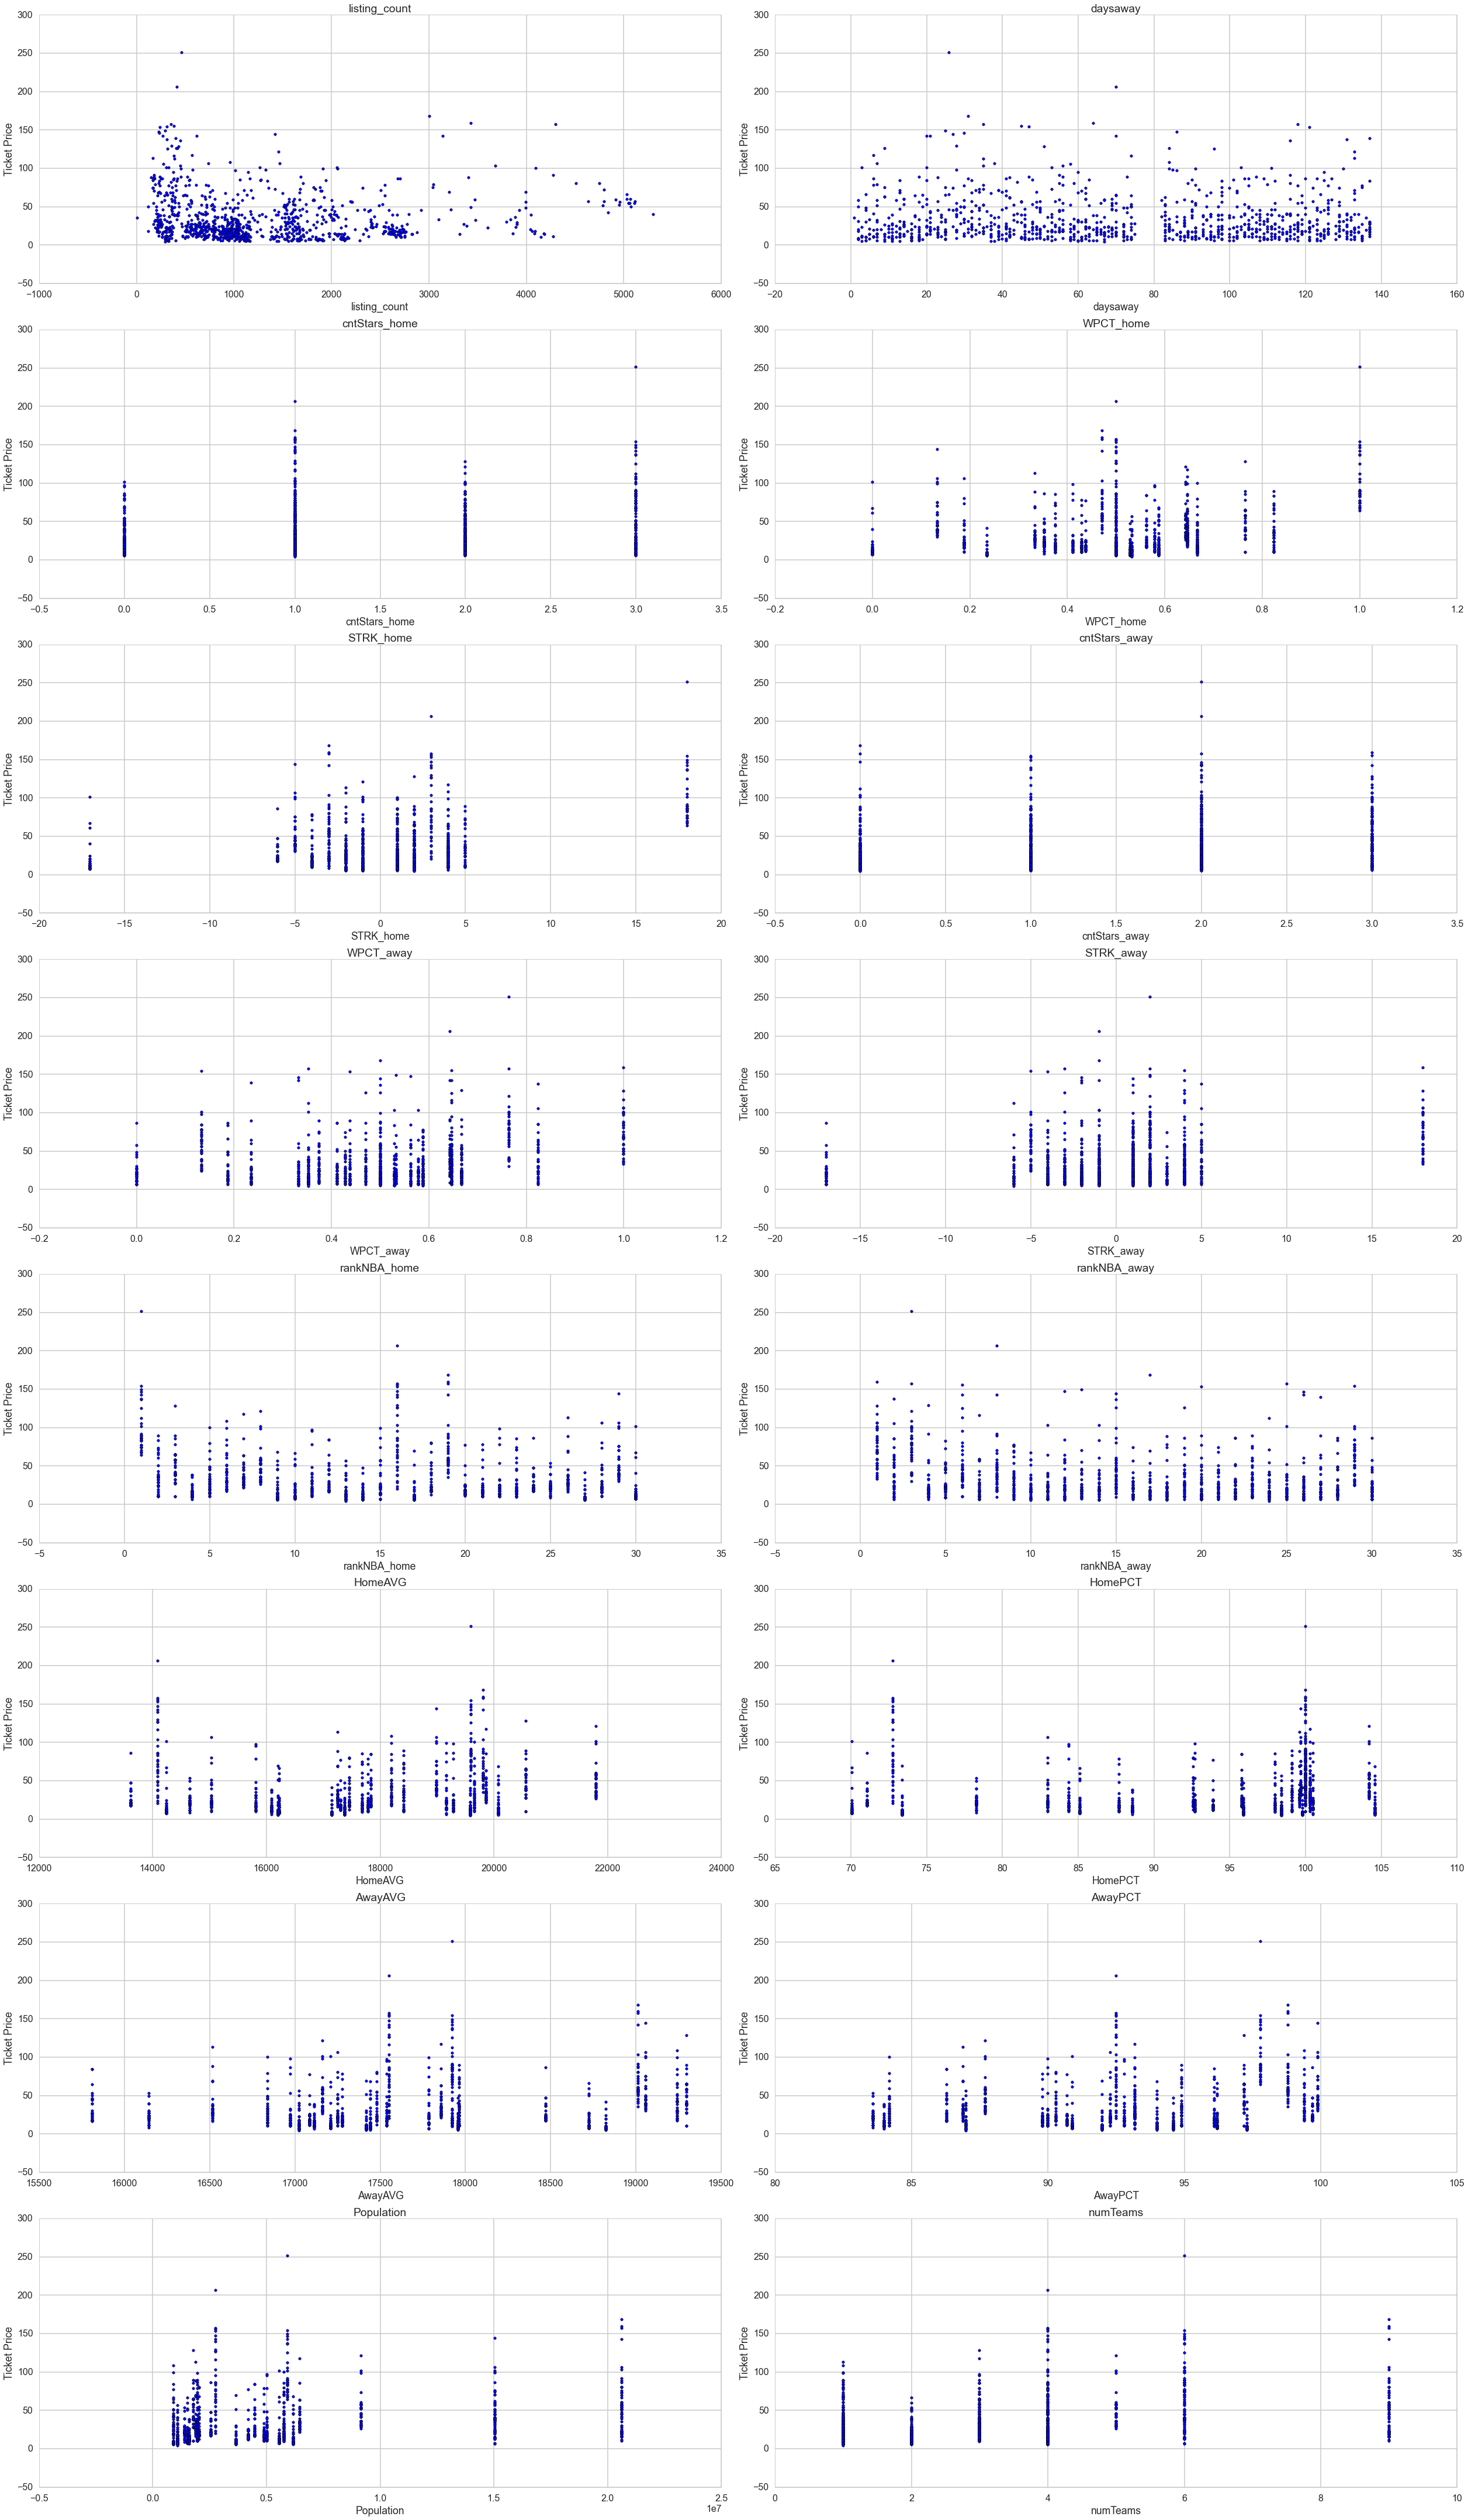

In [108]:
# examine the more continuous variables for transformations
continuousvariables = ['listing_count',
 'daysaway',
 'cntStars_home',
 'WPCT_home',
 'STRK_home',
 'cntStars_away',
 'WPCT_away',
 'STRK_away',
 'rankNBA_home',
 'rankNBA_away',
 'HomeAVG',
 'HomePCT',
 'AwayAVG',
 'AwayPCT',
 'Population',
 'numTeams',
 'holiday']


fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(35, 60), tight_layout=True)
for ax, xvar in zip(axes.ravel(), continuousvariables):
    ax.scatter(regdf[xvar], regdf["lowest_price_good"])
    ax.set_title(xvar)
    ax.set_xlabel(xvar)
    ax.set_ylabel('Ticket Price')

Again, we log transform population and daysaway to create better linear relationships, as seen in the side-by-side plots below:

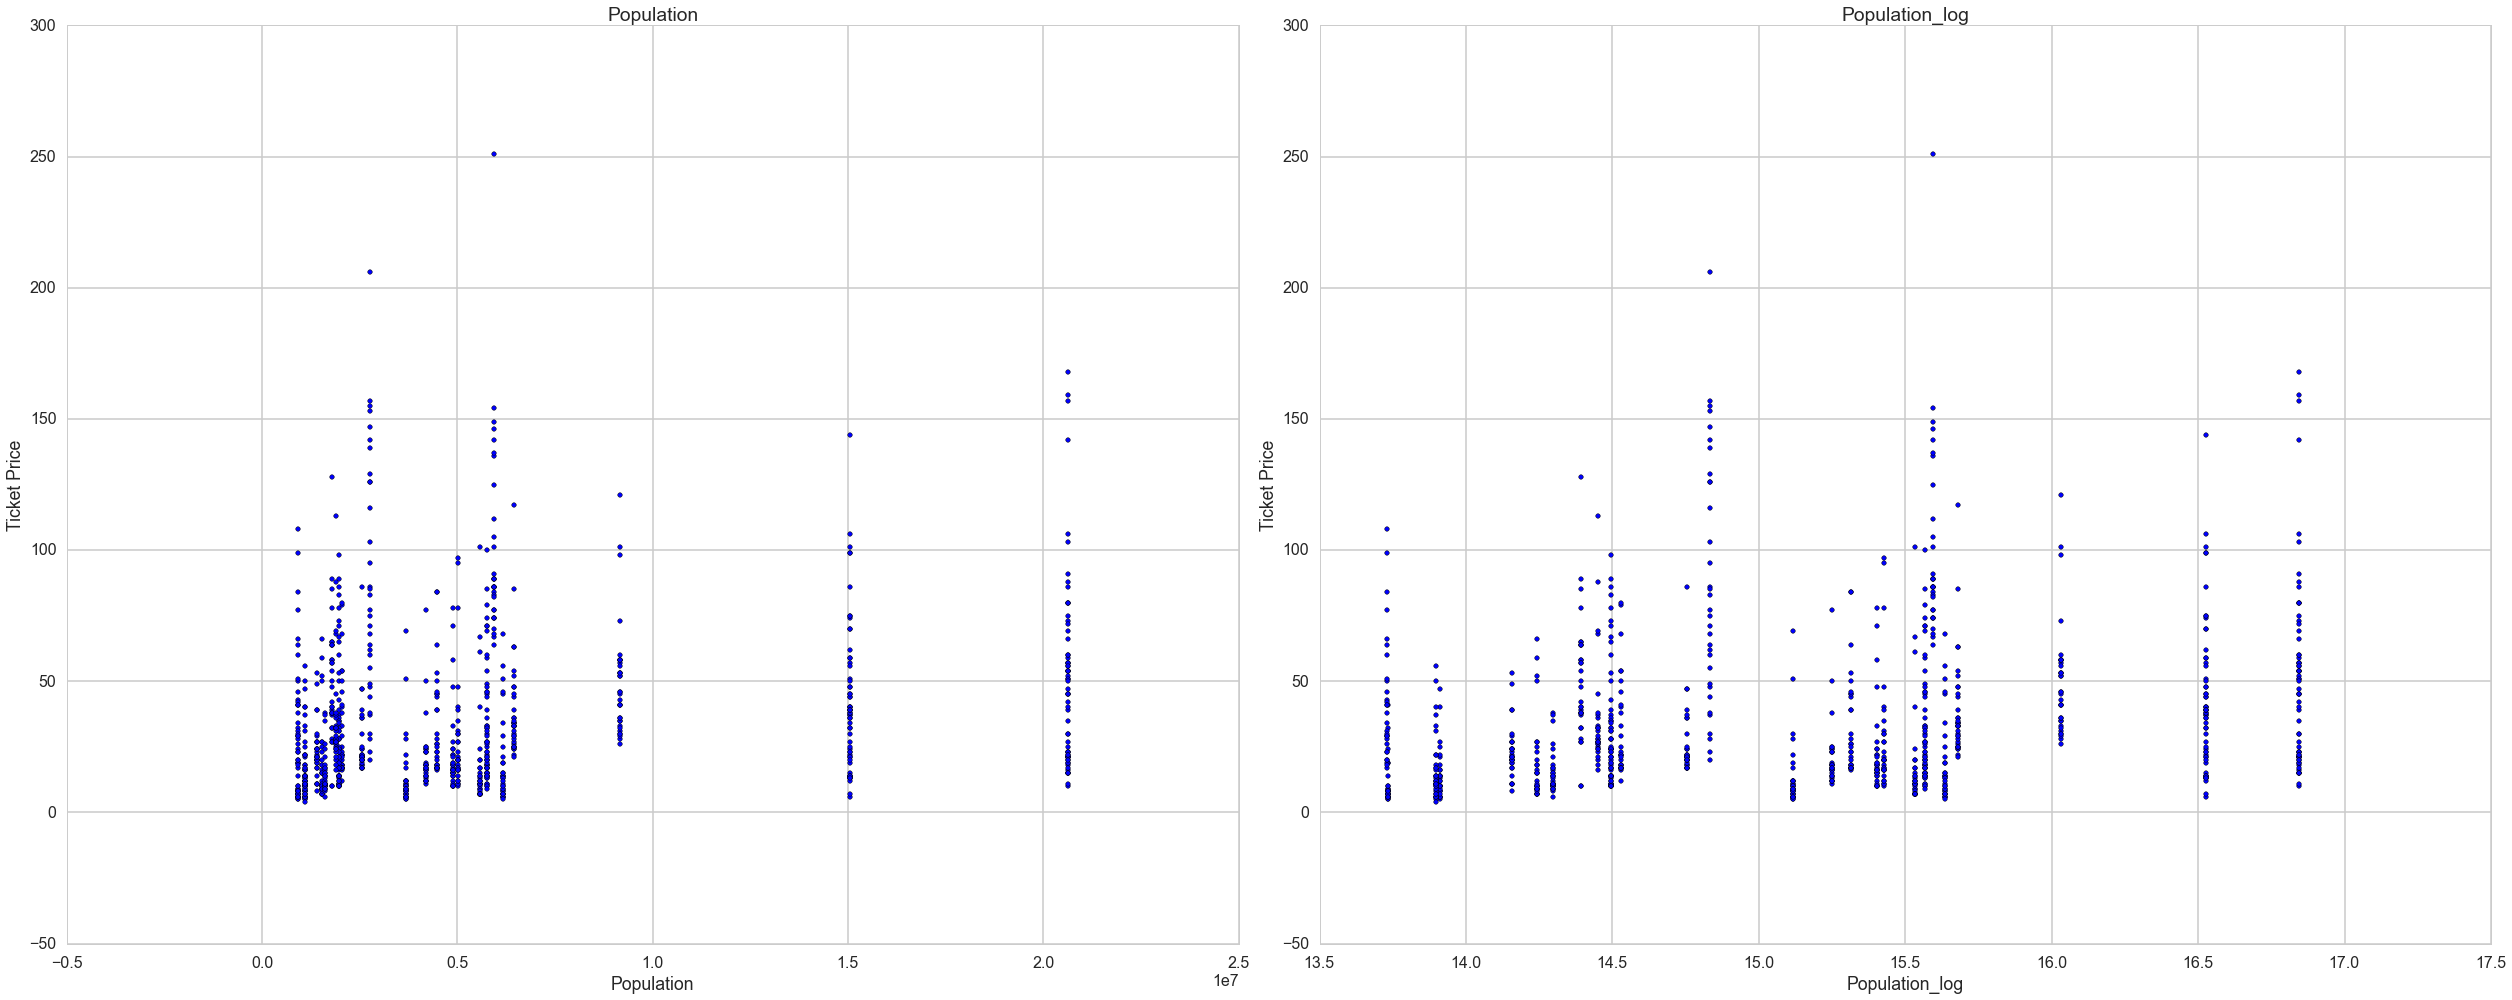

In [109]:
regdf["Population_log"] = np.log(regdf["Population"])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(35, 14), tight_layout=True)
for ax, xvar in zip(axes.ravel(), ["Population", "Population_log"]):
    ax.scatter(regdf[xvar], regdf["lowest_price_good"])
    ax.set_title(xvar)
    ax.set_xlabel(xvar)
    ax.set_ylabel('Ticket Price')

We also see that the variance in daysaway might allow the effect of daysaway to be better captured by logging the variable.

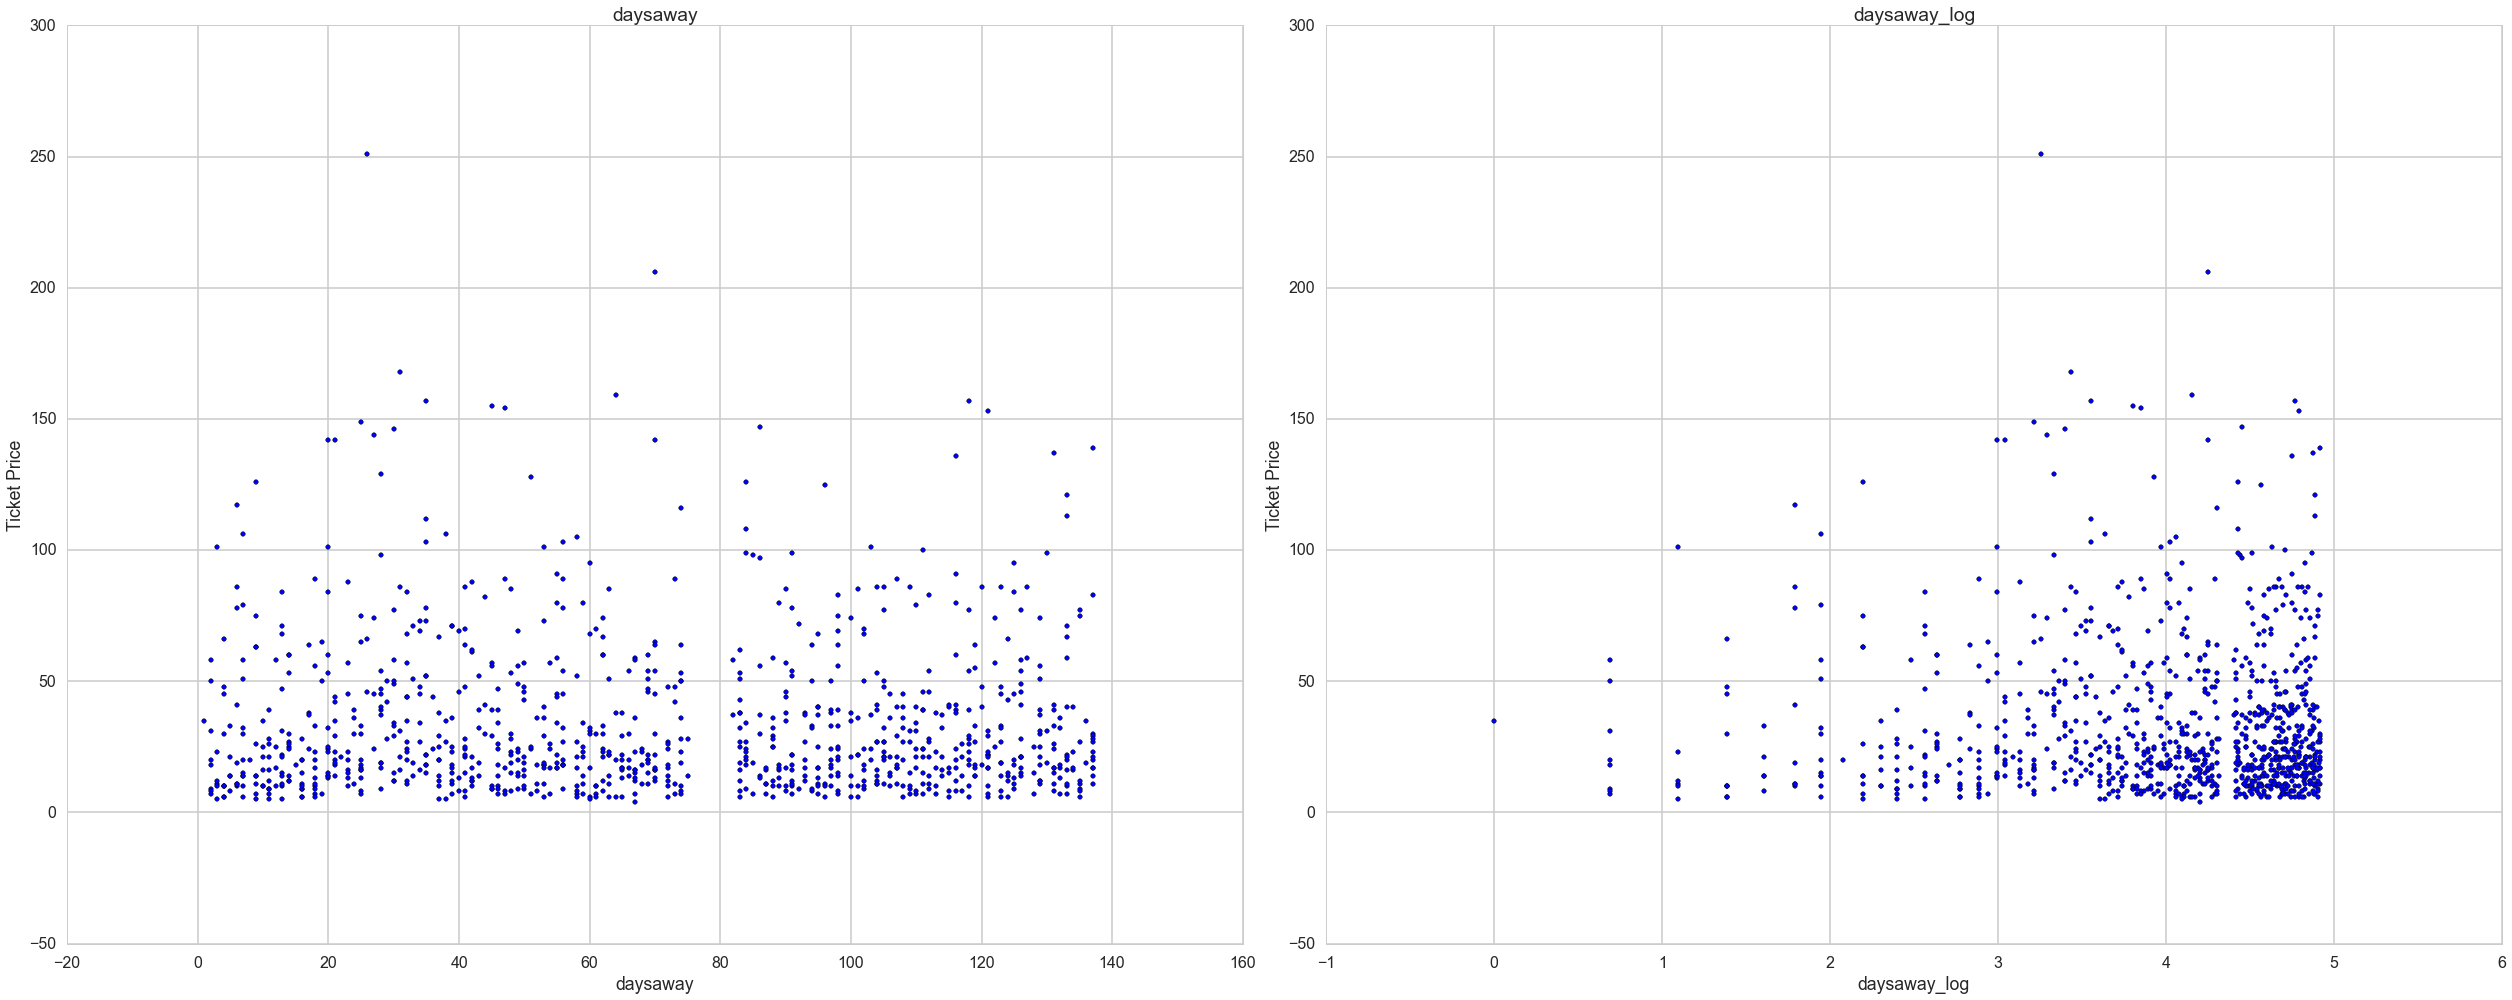

In [110]:
regdf["daysaway_log"] = np.log(regdf["daysaway"])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(35, 14), tight_layout=True)
for ax, xvar in zip(axes.ravel(), ["daysaway", "daysaway_log"]):
    ax.scatter(regdf[xvar], regdf["lowest_price_good"])
    ax.set_title(xvar)
    ax.set_xlabel(xvar)
    ax.set_ylabel('Ticket Price')

## c. Define Model Formulas and Set Up DataFrame for Regression

***As above, we define models according to three sets of predictors:***

- **Simple set: the relevant predictors without any potentially redundant information. Because the data is from a snapshot in time, team rankings and location-related predictors are exactly associated with a single team. We omitted team indicators to eliminate potential redundancies.**


- **Intuitive set: the simple set plus the potentially redundant team indicator variables. We call this "intuitive" because it encapsulates all intuitively useful predictors.**


- **All set: this is the intuitive set plus nearly all other two-way combinations for interaction terms. We merely excluded interactions with the weekdays and away teams, as we felt the number of predictors these would add would be too substantial for the potential benefit. Having used interaction terms in other courses substantially, we felt that this would be an interesting way to test the limits of the "predictor-selecting" models we explored in CS 109 (we used Ridge, Lasso, and Elastic Nets - more on this later). Including a ton of potentially relevant information in these models might cause them to find the "gems" among the all of the "junk" and produce excellent predictions.**

***We print the model statements for each of these three sets below. The only difference from the other model is that y-variable is today's price rather than the price from a week out and the resulting fact that we can no longer use today's price as a predictor.***

Define variables for each model:

In [111]:
xvarssimple = ['listing_count',
 'daysaway_log',
 'cntStars_home',
 'WPCT_home',
 'STRK_home',            
 'STRK_home',                        
 'cntStars_away',
 'WPCT_away',
 'STRK_away',            
 'STRK_away',                        
 'rankNBA_home',
 'rankNBA_away',            
 'HomeAVG',
 'HomePCT',
 'AwayAVG',
 'AwayPCT',
 'Population_log',
 'numTeams',
 'holiday'
  ]

xvarsintuitive = xvarssimple

# make interaction terms to include in the "all" model
listVar=['listing_count',
 'daysaway_log',
 'cntStars_home',
 'WPCT_home',                     
 'cntStars_away',
 'WPCT_away',                            
 'rankNBA_home',
 'rankNBA_away',            
 'HomeAVG',
 'HomePCT',
 'AwayAVG',
 'AwayPCT',
 'Population_log',
 'numTeams',
 'holiday']
listInteract=[]
for num in range(len(listVar)):
    for num1 in range(num,len(listVar)):
        if num != num1:
            name = listVar[num]+':'+listVar[num1]
            if name not in xvarsintuitive:
                listInteract.append(name)
xvarsall = xvarsintuitive + listInteract

Create binary variable columns and names for teams to make interaction term calculation easier:

In [113]:
# # Add home team and home team interaction terms:
hometeams = list(np.unique(regdf["home_team"]))
# drop the first venue
del hometeams[0]
regdf = regdf.reset_index()

hometeamslist = []
justteamshome = []

count = 1
for team in hometeams:
    temp = np.zeros(len(regdf["home_team"]))
    #temp[regdf["venuename"].isin(list(venue))] = True
    for i in range(0,len(temp)):
        if regdf.loc[i,"home_team"] == team:
            temp[i] = 1
    name = team.replace(" ","") + "_home"
    regdf[name] = temp
    justteamshome.append(name)
    name = name + ":daysaway_log"
    hometeamslist.append(name)
    count = count + 1


    
xvarsall = xvarsall + hometeamslist + justteamshome
xvarsintuitive = xvarsintuitive + justteamshome
xvarssimple = xvarssimple


# # Add away team and away team interaction terms:
awayteams = list(np.unique(regdf["away_team"]))
# drop the first venue
del awayteams[0]

awayteamslist = []
justteamsaway = []

count = 1
for team in awayteams:
    temp = np.zeros(len(regdf["away_team"]))
    #temp[regdf["venuename"].isin(list(venue))] = True
    for i in range(0,len(temp)):
        if regdf.loc[i,"away_team"] == team:
            temp[i] = 1
    name = team.replace(" ","") + "_away"
    regdf[name] = temp
    justteamsaway.append(name)
    name = name + ":daysaway_log"
    awayteamslist.append(name)
    count = count + 1


    
xvarsall = xvarsall + justteamsaway
xvarsintuitive = xvarsintuitive + justteamsaway
xvarssimple = xvarssimple


# # sources: http://stackoverflow.com/questions/8270092/python-remove-all-whitespace-in-a-string

Create binary variable columns and names for days of the week:

In [114]:
# # Add weekday and weekday interaction terms:
weekdays = list(np.unique(regdf["weekday"]))
# drop the first venue
del weekdays[0]
weekdaylist = []


count = 1
for weekday in weekdays:
    temp = np.zeros(len(regdf["weekday"]))
    for i in range(0,len(temp)):
        if regdf.loc[i,"weekday"] == weekday:
            temp[i] = 1
    name = weekday
    regdf[name] = temp
    weekdaylist.append(name)
    count = count + 1

xvarsall = xvarsall + weekdaylist
xvarsintuitive = xvarsintuitive + weekdaylist
xvarssimple = xvarssimple + weekdaylist

Programatically calculate interaction terms:

In [115]:
# make interaction terms
for xvar in xvarsall:
    if xvar.find(":") != -1:
        var1,var2 = xvar.split(":")
        temp = regdf[var1]*regdf[var2]
        regdf[xvar] = temp

Use the work above to create the forumulas for the regressions. Then, print those formulas:

In [116]:
# simple model
formulasimple = str("lowest_price_good ~ ") + xvarssimple[0]
count = 0
for xvar in xvarssimple:
    if count > 0:
        formulasimple = formulasimple + "+" + xvar
    count = count + 1

print formulasimple

lowest_price_good ~ listing_count+daysaway_log+cntStars_home+WPCT_home+STRK_home+STRK_home+cntStars_away+WPCT_away+STRK_away+STRK_away+rankNBA_home+rankNBA_away+HomeAVG+HomePCT+AwayAVG+AwayPCT+Population_log+numTeams+holiday+Monday+Saturday+Sunday+Thursday+Tuesday+Wednesday


In [117]:
# intuitive model
formulaintuitive = str("lowest_price_good ~ ") + xvarsintuitive[0]
count = 0
for xvar in xvarsintuitive:
    if count > 0:
        formulaintuitive = formulaintuitive + "+" + xvar
    count = count + 1

print formulaintuitive

lowest_price_good ~ listing_count+daysaway_log+cntStars_home+WPCT_home+STRK_home+STRK_home+cntStars_away+WPCT_away+STRK_away+STRK_away+rankNBA_home+rankNBA_away+HomeAVG+HomePCT+AwayAVG+AwayPCT+Population_log+numTeams+holiday+BostonCeltics_home+BrooklynNets_home+CharlotteHornets_home+ChicagoBulls_home+ClevelandCavaliers_home+DallasMavericks_home+DenverNuggets_home+DetroitPistons_home+GoldenStateWarriors_home+HoustonRockets_home+IndianaPacers_home+LosAngelesClippers_home+LosAngelesLakers_home+MemphisGrizzlies_home+MiamiHeat_home+MilwaukeeBucks_home+MinnesotaTimberwolves_home+NewOrleansPelicans_home+NewYorkKnicks_home+OklahomaCityThunder_home+OrlandoMagic_home+Philadelphia76ers_home+PhoenixSuns_home+PortlandTrailBlazers_home+SacramentoKings_home+SanAntonioSpurs_home+TorontoRaptors_home+UtahJazz_home+WashingtonWizards_home+BostonCeltics_away+BrooklynNets_away+CharlotteHornets_away+ChicagoBulls_away+ClevelandCavaliers_away+DallasMavericks_away+DenverNuggets_away+DetroitPistons_away+GoldenSt

In [120]:
# complex model
formulaall = str("lowest_price_good ~ ") + xvarsall[0]
count = 0
for xvar in xvarsall:
    if count > 0:
        formulaall = formulaall + "+" + xvar
    count = count + 1

print formulaall

lowest_price_good ~ listing_count+daysaway_log+cntStars_home+WPCT_home+STRK_home+STRK_home+cntStars_away+WPCT_away+STRK_away+STRK_away+rankNBA_home+rankNBA_away+HomeAVG+HomePCT+AwayAVG+AwayPCT+Population_log+numTeams+holiday+listing_count:daysaway_log+listing_count:cntStars_home+listing_count:WPCT_home+listing_count:cntStars_away+listing_count:WPCT_away+listing_count:rankNBA_home+listing_count:rankNBA_away+listing_count:HomeAVG+listing_count:HomePCT+listing_count:AwayAVG+listing_count:AwayPCT+listing_count:Population_log+listing_count:numTeams+listing_count:holiday+daysaway_log:cntStars_home+daysaway_log:WPCT_home+daysaway_log:cntStars_away+daysaway_log:WPCT_away+daysaway_log:rankNBA_home+daysaway_log:rankNBA_away+daysaway_log:HomeAVG+daysaway_log:HomePCT+daysaway_log:AwayAVG+daysaway_log:AwayPCT+daysaway_log:Population_log+daysaway_log:numTeams+daysaway_log:holiday+cntStars_home:WPCT_home+cntStars_home:cntStars_away+cntStars_home:WPCT_away+cntStars_home:rankNBA_home+cntStars_home:rank

## d. Sample Games and Run a Cross-Validation

***Again, we ran the three sets of predictors on the following four models, to produce a total of 12 fit models.***

- **OLS Regression: this is the simplest, go-to model, and we expect it to perform worse than the others, which might filter out unnecessary data well.**


- **Ridge Regression: we used this because it ought to set the coefficients of less valuable predictors to near-zero values, which could produce excellent predictions given a large number of predictors.**


- **Lasso Regression: we used this because it ought to set the coefficients of less valuable predictors to zero values, which could produce excellent predictions given a large number of predictors.**


- **Elastic Net: we used this for similar reasons to the above.**

***Again, we trained and validated each of these on the following three predictor sets:***

- **Simple set**

- **Intuitive set**

- **All set**

***The model statements for these three predictors sets are printed above.***

Again, instead of using k-fold cross-validations as in lecture, we split the data into testing and other data and then sampled randomly from that other data to produce training and validation sets. We did this because, given our large set of predictors and limited data, we wanted to ensure a large amount of data for fitting and a large amount of data for testing the models. Random sampling should avoid biases in this method. In the end, it allowed us to validate on a "larger" set of data; by doing 30 samples of 80 validation datapoints, we were able to validate on a total of 2400 points, far more than our dataset of roughly 800 datapoints that would be available in k-fold validation.

Sample game ids and store the samples to have reproducible results:

In [121]:

######## Rerunning will overwrite reproducible results

# # sample by game ID number to avoid any indexing differences
# # store results (like choosing a seed)

# uniqueids = regdf.id
# traininglength = 648
# testinglength = 80
# validatelength = 80

# testids = np.random.choice(a = uniqueids, size = testinglength, replace = False)
# remainingids = list([x for x in uniqueids if x not in testids])

# trainidsdf = pd.DataFrame()
# testidsdf = pd.DataFrame()
# remainingidsdf = pd.DataFrame()
# for i in range(30):
#     trainidsdf[i] = np.random.choice(a = remainingids, size = traininglength, replace = False)
# testidsdf[0] = testids
# remainingidsdf[0] = remainingids
    
# trainidsdf.to_csv("trainidsdf.csv")
# testidsdf.to_csv("testidsdf.csv")
# remainingidsdf.to_csv("remainingidsdf.csv")
    
print "complete"

complete


Execute the cross validation, storing RMSE (Euclidean Distance) and MAD (Manhattan Distance) as prediction accuracy metrics:

In [122]:
%%time

trainidsdf = pd.DataFrame.from_csv("trainidsdf.csv")
uniqueids = np.unique(regdf.id)
reaminingids = pd.DataFrame.from_csv("remainingidsdf.csv")
reaminingids = list(reaminingids["0"])
uniqueids = np.unique(regdf.id)


# Stats for the Simple Model
olsmsessimple = []
olsmadssimple = []
ridgemsessimple = []
ridgemadssimple = []
lassomsessimple = []
lassomadssimple = []
enetmsessimple = []
enetmadssimple = []

# Stats for the Intuitive Model
olsmsesintuitive = []
olsmadsintuitive = []
ridgemsesintuitive = []
ridgemadsintuitive = []
lassomsesintuitive = []
lassomadsintuitive = []
enetmsesintuitive = []
enetmadsintuitive = []

# Stats for the Full Model
olsmsesall = []
olsmadsall = []
ridgemsesall = []
ridgemadsall = []
lassomsesall = []
lassomadsall = []
enetmsesall = []
enetmadsall = []


# Cross-Validate
for i in trainidsdf.columns.values:
    trainids = trainidsdf[i]
    validateids = set(remainingids) - set(trainids)
    
    traindf = regdf.loc[regdf["id"].isin(trainids)]
    validatedf = regdf.loc[regdf["id"].isin(validateids)]
    
    # make simple model x and y dataframes
    forfitsimple = pd.DataFrame(traindf.lowest_price_good)
    forpredsimple = pd.DataFrame(validatedf.lowest_price_good)
    for xvar in xvarssimple:
        forpredsimple[xvar] = validatedf[xvar]
        forfitsimple[xvar] = traindf[xvar]
    ytrainsimple,xtrainsimple = patsy.dmatrices(formulasimple, data=forfitsimple)
    yvalidatesimple,xvalidatesimple = patsy.dmatrices(formulasimple, data=forpredsimple)

    
    # make intuitive model x and y dataframes
    forfitintuitive = pd.DataFrame(traindf.lowest_price_good)
    forpredintuitive = pd.DataFrame(validatedf.lowest_price_good)
    for xvar in xvarsintuitive:
        forpredintuitive[xvar] = validatedf[xvar]
        forfitintuitive[xvar] = traindf[xvar]
    ytrainintuitive,xtrainintuitive = patsy.dmatrices(formulaintuitive, data=forfitintuitive)
    yvalidateintuitive,xvalidateintuitive = patsy.dmatrices(formulaintuitive, data=forpredintuitive)
    
    
    
    # make full model x and y dataframes    
    forfitall = pd.DataFrame(traindf.lowest_price_good)
    forpredall = pd.DataFrame(validatedf.lowest_price_good)
    for xvar in xvarsall:
        forpredall[xvar] = validatedf[xvar]
        forfitall[xvar] = traindf[xvar]
    ytrainall,xtrainall = patsy.dmatrices(formulaall, data=forfitall)
    yvalidateall,xvalidateall = patsy.dmatrices(formulaall, data=forpredall)
    
    
    
    
# Simple Models    

    # linear
    fit = ols(formulasimple, data = forfitsimple).fit()
    preds = fit.predict(forpredsimple)
    prederrors = []
    count = 0
    for act in yvalidatesimple:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    olsmsessimple.append(np.mean(squarelist(prederrors)))
    olsmadssimple.append(np.mean(abslist(prederrors))) 
    
    # ridge
    fitridge = cv_optimize_ridge(xtrainsimple, ytrainsimple, n_folds=8)
    alpharidge = fitridge.best_params_['alpha']
    clfridge = Ridge(alpha=alpharidge).fit(xtrainsimple,ytrainsimple)
    preds = clfridge.predict(xvalidatesimple)
    prederrors = []
    count = 0
    for act in yvalidatesimple:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    ridgemsessimple.append(np.mean(squarelist(prederrors)))
    ridgemadssimple.append(np.mean(abslist(prederrors))) 
    
    # lasso
    fitlasso = cv_optimize_lasso(xtrainsimple, ytrainsimple, n_folds=8)
    alphalasso = fitlasso.best_params_['alpha']
    clflasso = Lasso(alpha=alphalasso).fit(xtrainsimple,ytrainsimple)
    preds = clflasso.predict(xvalidatesimple)
    prederrors = []
    count = 0
    for act in yvalidatesimple:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    lassomsessimple.append(np.mean(squarelist(prederrors)))
    lassomadssimple.append(np.mean(abslist(prederrors)))  

    # enet
    fitenet = cv_optimize_enet(xtrainsimple, forfitsimple["lowest_price_good"], n_folds=8)
    alphaenet = fitenet.best_params_['alpha']
    clfenet = ElasticNet(alpha=alphaenet).fit(xtrainsimple,forfitsimple["lowest_price_good"])
    preds = clfenet.predict(xvalidatesimple)
    prederrors = []
    count = 0
    for act in yvalidatesimple:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    enetmsessimple.append(np.mean(squarelist(prederrors)))
    enetmadssimple.append(np.mean(abslist(prederrors)))       
    
    
    
# Models with Seemingly Reasonable Interactions by Intuition

    # linear
    fit = ols(formulaintuitive, data = forfitintuitive).fit()
    preds = fit.predict(forpredintuitive)    
    prederrors = []
    count = 0
    for act in yvalidateintuitive:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    olsmsesintuitive.append(np.mean(squarelist(prederrors)))
    olsmadsintuitive.append(np.mean(abslist(prederrors))) 
        
    
    # ridge
    fitridge = cv_optimize_ridge(xtrainintuitive, ytrainintuitive, n_folds=8)
    alpharidge = fitridge.best_params_['alpha']
    clfridge = Ridge(alpha=alpharidge).fit(xtrainintuitive,ytrainintuitive)
    preds = clfridge.predict(xvalidateintuitive)
    prederrors = []
    count = 0
    for act in yvalidateintuitive:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    ridgemsesintuitive.append(np.mean(squarelist(prederrors)))
    ridgemadsintuitive.append(np.mean(abslist(prederrors)))
    
    
    # lasso
    fitlasso = cv_optimize_lasso(xtrainintuitive, ytrainintuitive, n_folds=8)
    alphalasso = fitlasso.best_params_['alpha']
    clflasso = Lasso(alpha=alphalasso).fit(xtrainintuitive,ytrainintuitive)
    preds = clflasso.predict(xvalidateintuitive)
    prederrors = []
    count = 0
    for act in yvalidateintuitive:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    lassomsesintuitive.append(np.mean(squarelist(prederrors)))
    lassomadsintuitive.append(np.mean(abslist(prederrors))) 

    # enet
    fitenet = cv_optimize_enet(xtrainintuitive, forfitintuitive["lowest_price_good"], n_folds=8)
    alphaenet = fitenet.best_params_['alpha']
    clfenet = ElasticNet(alpha=alphaenet).fit(xtrainintuitive,forfitintuitive["lowest_price_good"])
    preds = clfenet.predict(xvalidateintuitive)
    prederrors = []
    count = 0
    for act in yvalidateintuitive:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    
    enetmsesintuitive.append(np.mean(squarelist(prederrors)))
    enetmadsintuitive.append(np.mean(abslist(prederrors)))
    
    
# Models with Nearly All Interaction Terms
    # linear
    fit = ols(formulaall, data = forfitall).fit()
    preds = fit.predict(forpredall)    
    prederrors = []
    count = 0
    for act in yvalidateall:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    olsmsesall.append(np.mean(squarelist(prederrors)))
    olsmadsall.append(np.mean(abslist(prederrors))) 
        
    
    # ridge
    fitridge = cv_optimize_ridge(xtrainall, ytrainall, n_folds=8)
    alpharidge = fitridge.best_params_['alpha']
    clfridge = Ridge(alpha=alpharidge).fit(xtrainall,ytrainall)
    preds = clfridge.predict(xvalidateall)
    prederrors = []
    count = 0
    for act in yvalidateall:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    ridgemsesall.append(np.mean(squarelist(prederrors)))
    ridgemadsall.append(np.mean(abslist(prederrors))) 
    
    
    # lasso
    fitlasso = cv_optimize_lasso(xtrainall, ytrainall, n_folds=8)
    alphalasso = fitlasso.best_params_['alpha']
    clflasso = Lasso(alpha=alphalasso).fit(xtrainall,ytrainall)
    preds = clflasso.predict(xvalidateall)
    prederrors = []
    count = 0
    for act in yvalidateall:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    lassomsesall.append(np.mean(squarelist(prederrors)))
    lassomadsall.append(np.mean(abslist(prederrors))) 

    # enet
    fitenet = cv_optimize_enet(xtrainall, forfitall["lowest_price_good"], n_folds=8)
    alphaenet = fitenet.best_params_['alpha']
    clfenet = ElasticNet(alpha=alphaenet).fit(xtrainall,forfitall["lowest_price_good"])
    preds = clfenet.predict(xvalidateall)
    prederrors = []
    count = 0
    for act in yvalidateall:
        prederrors.append(float(preds[count] - float(act)))
        count = count + 1
    
    enetmsesall.append(np.mean(squarelist(prederrors)))
    enetmadsall.append(np.mean(abslist(prederrors)))
    

    
    
    
# sources: http://stackoverflow.com/questions/2104305/finding-elements-not-in-a-list, http://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas, http://statsmodels.sourceforge.net/0.6.0/examples/notebooks/generated/predict.html, http://stackoverflow.com/questions/20724919/pandas-dataframe-attributeerror-dataframe-object-has-no-attribute-design-inf

CPU times: user 21min 32s, sys: 13.7 s, total: 21min 46s
Wall time: 21min 52s


## e. Examine the Cross Validation Results

***We look at mean squared error and mean absolute deviations between predicted ticket prices and actual ticket prices to determine which model has predictions that are "closest" to the actual outcomes. We see that the Elastic Net model on the Intuitive Set of predictors performs best by both metrics. Given that the Elastic Net ends up setting the coefficent on "daysaway" to 0, it cannot be used for prediction in the method described above. Therefore, we continue both with it and with the next best model, the Lasso on the Intuitive Set of Predictors.***


***Interesting, adding too much "garbage" did not succeed to become best with the "predictor-selecting" models, though the Lasso on the All Set of predictors performed almost as well as the other models by RMSE (not so well by MAD). However, it must be noted that the models fit on the All Set performed far better than with the Simple Set. This speaks to the capabilities of the "predictor-selecting" models, though OLS also improved significantly with the addition of all of these predictors.***

Make Table of MSE Results:

In [123]:
Simple = [round(np.sqrt(np.mean(olsmsessimple)),2), round(np.sqrt(np.mean(ridgemsessimple)),2), round(np.sqrt(np.mean(lassomsessimple)),2), round(np.sqrt(np.mean(enetmsessimple)),2)]
Intuitive = [round(np.sqrt(np.mean(olsmsesintuitive)),2), round(np.sqrt(np.mean(ridgemsesintuitive)),2), round(np.sqrt(np.mean(lassomsesintuitive)),2), round(np.sqrt(np.mean(enetmsesintuitive)),2)]
All = [round(np.sqrt(np.mean(olsmsesall)),2), round(np.sqrt(np.mean(ridgemsesall)),2), round(np.sqrt(np.mean(lassomsesall)),2), round(np.sqrt(np.mean(enetmsesall)),2)]

MSEResultstable = pd.DataFrame()
MSEResultstable["Simple"] = Simple
MSEResultstable["Intuitive"] = Intuitive
MSEResultstable["All"] = All
MSEResultstable.index = ["OLS","Ridge","Lasso", "ElasticNet"]
print "Cross Validation Root Avg. MSE Today's Price:"
MSEResultstable

Cross Validation Root Avg. MSE Today's Price:


Simple  Intuitive    All
OLS          25.37      16.08  18.25
Ridge        25.61      16.31  20.53
Lasso        25.49      16.08  16.84
ElasticNet   25.60      16.04  17.33

Make Barplot of MSE Results:

RMSE Results for Different Models of Today's Price:


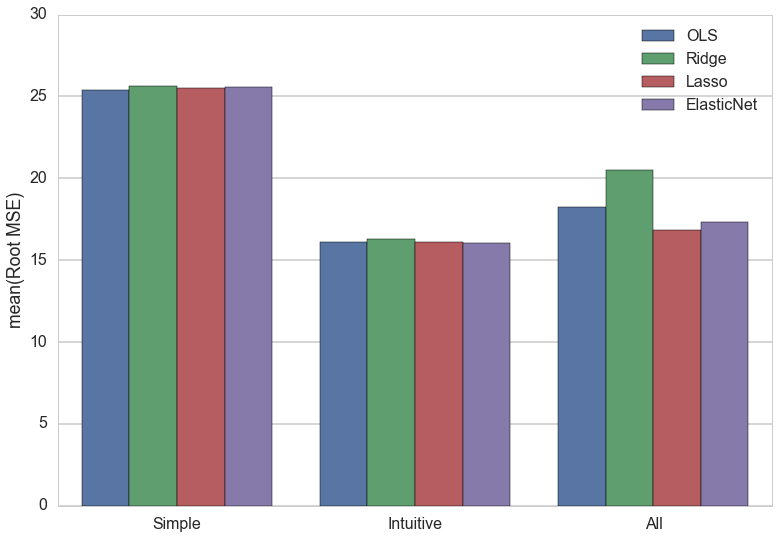

In [124]:
MSE = Simple + Intuitive + All
forplottable = pd.DataFrame()
forplottable["Root MSE"] = MSE
indices = [list(MSEResultstable.index) + list(MSEResultstable.index) + list(MSEResultstable.index)]
forplottable.index = indices
digits = ["Simple","Simple","Simple", "Simple"] + ["Intuitive","Intuitive","Intuitive","Intuitive"] + ["All","All","All", "All"]
forplottable["Digits"] = digits
sns.barplot(y = "Root MSE",x = digits, hue = forplottable.index.values, data = forplottable)
print "RMSE Results for Different Models of Today's Price:"

Make Table of MAD Results:

In [125]:
Simple = [round(np.mean(olsmadssimple),2), round(np.mean(ridgemadssimple),2), round(np.mean(lassomadssimple),2), round(np.mean(enetmadssimple),2)]
Intuitive = [round(np.mean(olsmadsintuitive),2), round(np.mean(ridgemadsintuitive),2), round(np.mean(lassomadsintuitive),2), round(np.mean(enetmadsintuitive),2)]
All = [round(np.mean(olsmadsall),2), round(np.mean(ridgemadsall),2), round(np.mean(lassomadsall),2), round(np.mean(enetmadsall),2)]

MADResultstable = pd.DataFrame()
MADResultstable["Simple"] = Simple
MADResultstable["Intuitive"] = Intuitive
MADResultstable["All"] = All
MADResultstable.index = ["OLS","Ridge","Lasso", "ElasticNet"]
print "Cross Validation Avg. MAD Today's Price:"
MADResultstable

Cross Validation Avg. MAD Today's Price:


Simple  Intuitive    All
OLS          17.50       9.49  10.57
Ridge        17.92       9.70  13.07
Lasso        17.75       9.47  10.16
ElasticNet   17.89       9.45  10.58

Make Barplot of MAD Results:

MAD Results for Different Models of Today's Price:


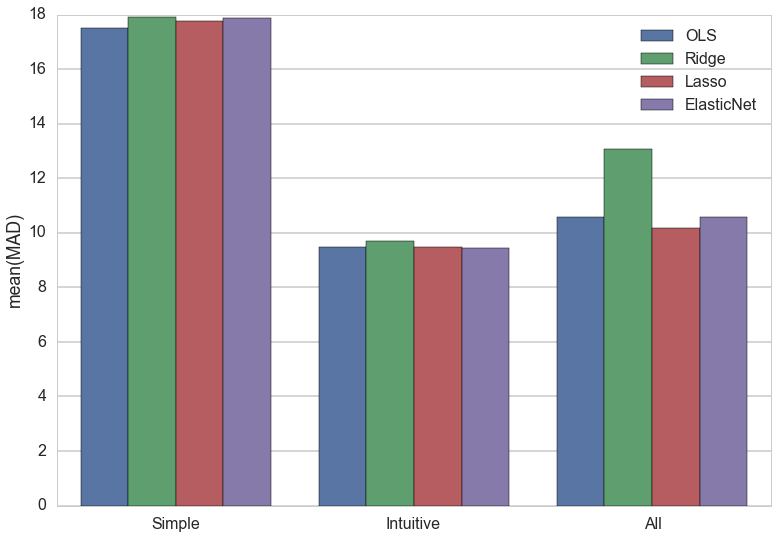

In [126]:
MAD = Simple + Intuitive + All
forplottable = pd.DataFrame()
forplottable["MAD"] = MAD
indices = [list(MADResultstable.index) + list(MADResultstable.index) + list(MADResultstable.index)]
forplottable.index = indices
digits = ["Simple","Simple","Simple", "Simple"] + ["Intuitive","Intuitive","Intuitive","Intuitive"] + ["All","All","All", "All"]
forplottable["Digits"] = digits
sns.barplot(y = "MAD",x = digits, hue = forplottable.index.values, data = forplottable)
print "MAD Results for Different Models of Today's Price:"

## f. Test the Best Models on the Test Set to Determine Unbiased Prediction Error

Set-up:

In [425]:
# data frame with just test ids
testids = list(pd.DataFrame.from_csv("testidsdf.csv")["0"])
dfforaccuracy = regdf.loc[regdf["id"].isin(testids)]
dfforfitaccuracy = regdf.loc[~regdf["id"].isin(testids)]

# make design matrix
foraccuracyfit = pd.DataFrame(dfforfitaccuracy.lowest_price_good)
foraccuracypred = pd.DataFrame(dfforaccuracy.lowest_price_good)
for xvar in xvarsall:
    foraccuracyfit[xvar] = dfforfitaccuracy[xvar]
    foraccuracypred[xvar] = dfforaccuracy[xvar]
ydataaccuracy,xdataaccuracy = patsy.dmatrices(formulaintuitive, data=foraccuracyfit)
ydataaccuracypred,xdataaccuracypred = patsy.dmatrices(formulaintuitive, data=foraccuracypred)


# fit enet
fitenetaccuracy = cv_optimize_enet(xdataaccuracy, ydataaccuracy, n_folds=8)
alphaenet = fitenetaccuracy.best_params_['alpha']
clfenetfull = ElasticNet(alpha=alphaenet).fit(xdataaccuracy,ydataaccuracy)

# lasso
fitlassoaccuracy = cv_optimize_lasso(xdataaccuracy, ydataaccuracy, n_folds=8)
alphalasso = fitlassoaccuracy.best_params_['alpha']
clflassofull = Lasso(alpha=alphalasso).fit(xdataaccuracy,ydataaccuracy)


# sources: http://stackoverflow.com/questions/19960077/how-to-implement-in-and-not-in-for-pandas-dataframe

Prediction:

In [155]:
# predictions
#enet
pred = clfenetfull.predict(xdataaccuracypred)
actuals = ydataaccuracypred


# errors
#enet
prederrors = []
count = 0
for act in actuals:
    prederrors.append(float(pred[count] - act))
    count = count + 1

# stats on validation set
statstableenet = pd.DataFrame()
statstableenet["Enet Accuracy"] = [round(np.sqrt(np.mean(squarelist(prederrors))),2), round(np.mean(abslist(prederrors)),2)]
statstableenet.index = ["RMSE","MAD"]
statstableenet


Enet Accuracy
RMSE          13.49
MAD            7.56

***The elastic net predictions tend to be within 7.56 dollars of today's actual price. While this is not bad for a ticket worth 100 dollars, it certainly does not bode well for our prediction goals, especially given that the model of next week's price tended to predict within roughly 3.90 dollars of the actual price in a week.***

In [156]:
# predictions
#lasso
pred = clflassofull.predict(xdataaccuracypred)
actuals = ydataaccuracypred


# errors
#enet
prederrors = []
count = 0
for act in actuals:
    prederrors.append(float(pred[count] - act))
    count = count + 1

# stats on validation set
statstablelasso = pd.DataFrame()
statstablelasso["Lasso Accuracy"] = [round(np.sqrt(np.mean(squarelist(prederrors))),2), round(np.mean(abslist(prederrors)),2)]
statstablelasso.index = ["RMSE","MAD"]
statstablelasso


Lasso Accuracy
RMSE           13.46
MAD             7.56

***Like the elastic net, the Lasso predictions tend to be within 7.56 dollars of today's actual price. Again, this certainly does not bode well for our prediction goals, especially given that the model of next week's price tended to predict within roughly 3.90 dollars of the actual price in a week.***

##g. Fit the Models on All Data to Examine Coefficients and Have a Model for Future Use

Elastic Net:

In [157]:
# make full model x and y dataframes    
forfitalldataintuitive = pd.DataFrame(regdf.lowest_price_good)
for xvar in xvarsintuitive:
    forfitalldataintuitive[xvar] = regdf[xvar]
ydataintuitive,xdataintuitive = patsy.dmatrices(formulaintuitive, data=forfitalldataintuitive)

# fit enet model
fitenet = cv_optimize_enet(xdataintuitive, ydataintuitive, n_folds=8)
alphaenet = fitridge.best_params_['alpha']
clfenetfull = ElasticNet(alpha=alphaenet).fit(xdataintuitive,ydataintuitive)

# set up table of all results
enetcoefstable = pd.DataFrame()
enetcoefstable["Predictor"] =  xdataintuitive.design_info.column_names
enetcoefstable["Coefficient"] = clfenetfull.coef_

# Coefficients > 0
above0indices = enetcoefstable.index[abs(enetcoefstable["Coefficient"]) > 0]
above0coefs = enetcoefstable.loc[above0indices,["Predictor","Coefficient"]]

# sources: http://stackoverflow.com/questions/4211209/remove-all-the-elements-that-occur-in-one-list-from-another


In [158]:
print "Coefficients with ABS > 0:"
above0coefs

Coefficients with ABS > 0:


Predictor  Coefficient
1   listing_count    -0.001477
11        HomeAVG     0.002215
13        AwayAVG     0.005121

***We see that the elastic net model only includes 3 non-zero coefficients. Those are listing count, home team attendance average and away team attendance average. While these are predictors that are VERY intuitively linked to ticket prices, it is somewhat surprising to see them as the ONLY predictors. How interesting that the model essentially chose supply and demand (tickets available and number of people who usually buy tickets). This may explain some of the error in prediction, but it certainly is EXTREMELY intuitive. As supply (listing_count) rises here, price ought to drop. As demand rises (HomeAVG and AwayAVG, price ought to rise). We have proven Econ 101 right! Again, we use the Lasso as well because it is the next best model that has a coefficient on 'daysaway,' which will allow us to make predictions.***

Lasso:

In [163]:
# fit lasso model
fitlasso = cv_optimize_lasso(xdataintuitive, ydataintuitive, n_folds=8)
alphalasso = fitlasso.best_params_['alpha']
clflassofull = Lasso(alpha=alphalasso).fit(xdataintuitive,ydataintuitive)

# set up table of all results
lassocoefstable = pd.DataFrame()
lassocoefstable["Predictor"] =  xdataintuitive.design_info.column_names
lassocoefstable["Coefficient"] = clflassofull.coef_


# Daysaway-related coefficients

count = 0
daysindices = []
for x in xdataintuitive.design_info.column_names:
    if str(x).find("daysaway") != -1:
        daysindices.append(count)
    count = count + 1

dayscoefs = lassocoefstable.loc[daysindices,["Predictor","Coefficient"]]


# Home teams coefficients

hometeamindices = lassocoefstable.index[lassocoefstable["Predictor"].isin(justteamshome) == 1]
hometeamcoefs = lassocoefstable.loc[hometeamindices,["Predictor","Coefficient"]]
hometeamcoefs

# Away teams coefficients

awayteamindices = lassocoefstable.index[lassocoefstable["Predictor"].isin(justteamsaway) == 1]
awayteamcoefs = lassocoefstable.loc[awayteamindices,["Predictor","Coefficient"]]
awayteamcoefs

# Days of week coefficients

count = 0
weekdaysindices = []
for x in xdataintuitive.design_info.column_names:
    if str(x) in (weekdays):
        weekdaysindices.append(count)
    count = count + 1
daysofweekcoefs = lassocoefstable.loc[weekdaysindices,["Predictor","Coefficient"]]


# All other coefficients

taken = []
for i in daysindices:
    taken.append(i)
for i in hometeamindices:
    taken.append(i)
for i in awayteamindices:
    taken.append(i)
for i in weekdaysindices:
    taken.append(i)
temp = range(0,len(clflassofull.coef_))
restofcoefs = [x for x in temp if x not in taken]

restcoefs = lassocoefstable.loc[restofcoefs,["Predictor","Coefficient"]]


# sources: http://stackoverflow.com/questions/4211209/remove-all-the-elements-that-occur-in-one-list-from-another

In [165]:
print "Coefficients Related to Days Away from Game:"
dayscoefs

Coefficients Related to Days Away from Game:


Predictor  Coefficient
2  daysaway_log     1.097144

***Unlike the model for next week's price, this model attributes a higher price as days away from the game increases, all else in the model held constant. This means that prices drop as the game gets nearer. Therefore, a buyer would want to WAIT to buy the ticket until the game comes closer.***

In [166]:
print "Home Team Coefficients:"
hometeamcoefs

Home Team Coefficients:


Predictor  Coefficient
18          BostonCeltics_home     6.060231
19           BrooklynNets_home   -23.321522
20       CharlotteHornets_home    -7.403197
21           ChicagoBulls_home    -0.000000
22     ClevelandCavaliers_home     0.000000
23        DallasMavericks_home   -14.767682
24          DenverNuggets_home    -0.000000
25         DetroitPistons_home   -23.110824
26    GoldenStateWarriors_home    19.447495
27         HoustonRockets_home    -2.264339
28          IndianaPacers_home    -5.298492
29     LosAngelesClippers_home   -17.263610
30       LosAngelesLakers_home     4.703517
31       MemphisGrizzlies_home     0.000000
32              MiamiHeat_home    12.003958
33         MilwaukeeBucks_home     8.826896
34  MinnesotaTimberwolves_home    49.107317
35     NewOrleansPelicans_home    -6.474831
36          NewYorkKnicks_home    19.555293
37    OklahomaCityThunder_home    15.834365
38           OrlandoMagic_home     3.025859
39      Philadelphia76ers_home     9.637110
40            PhoenixSuns_home   -14.373031
41   PortlandTrailBlazers_home    -0.000000
42        SacramentoKings_home    21.538890
43        SanAntonioSpurs_home    11.173538
44         TorontoRaptors_home    -6.468213
45               UtahJazz_home   -17.227305
46      WashingtonWizards_home     2.365875

***We should note that these coefficients are RELATIVE to the Atlanta Hawks. The Lasso on today's price has several interesting trends here. First, there is a massive boost to tickets when the Minnesota Timberwolves are the home team. The Warriors again have a postiive one, as do the Knicks and the Kings. The Lakers' is much less pronounced than in the next week model. The Pistons and the Nets have very negative coefficients.***

In [167]:
print "Away Team Coefficients:"
awayteamcoefs

Away Team Coefficients:


Predictor  Coefficient
47          BostonCeltics_away     1.656318
48           BrooklynNets_away    -2.033308
49       CharlotteHornets_away    -3.568554
50           ChicagoBulls_away    18.724733
51     ClevelandCavaliers_away    50.862240
52        DallasMavericks_away    -4.071538
53          DenverNuggets_away     0.000000
54         DetroitPistons_away     1.945863
55    GoldenStateWarriors_away    39.999225
56         HoustonRockets_away     4.380006
57          IndianaPacers_away    -4.801007
58     LosAngelesClippers_away    17.478063
59       LosAngelesLakers_away    35.681895
60       MemphisGrizzlies_away    -2.421109
61              MiamiHeat_away     2.071460
62         MilwaukeeBucks_away     2.263476
63  MinnesotaTimberwolves_away    -2.005641
64     NewOrleansPelicans_away     1.761478
65          NewYorkKnicks_away     8.221339
66    OklahomaCityThunder_away    17.737761
67           OrlandoMagic_away    -1.841056
68      Philadelphia76ers_away     0.000000
69            PhoenixSuns_away    -0.322092
70   PortlandTrailBlazers_away    -4.873355
71        SacramentoKings_away    -0.000000
72        SanAntonioSpurs_away    10.795672
73         TorontoRaptors_away    -0.000000
74               UtahJazz_away    -4.769176
75      WashingtonWizards_away    -3.519184

***The away team trends are different, and we see that the Warriors and the Lakers have extremely high ones, while the Timberwolves now have a negative coefficient. This is a major reversal in the expected effect on ticket price, all else held constant. These coefficients make sense in the context of the average minimum ticket price plots that we examine in our EDA (pasted below). There, we saw this same switch for the Timberwolves. It is interesting to see that the switch remained when the other teams in the games were held constant.***

<img src="hometeamplot.png">

<img src="awayteamplot.png">

In [168]:
print "Coefficients on Week Days:"
daysofweekcoefs

Coefficients on Week Days:


Predictor  Coefficient
76     Monday    -3.675601
77   Saturday     4.926986
78     Sunday     6.682345
79   Thursday    -3.040972
80    Tuesday    -2.359931
81  Wednesday    -4.055949

***Here, Saturday and Sunday appear to fetch the highest prices relative to Friday, which makes intuitive sense. Wednesday should fetch the lowest, all else held constant, by this model. The Saturday and Sunday results are consistent with the average minimum ticket prices by day we saw in our EDA (pasted below).***

<img src="weekdayplot.png">

In [169]:
print "Other Coefficients:"
restcoefs

Other Coefficients:


Predictor  Coefficient
0        Intercept     0.000000
1    listing_count    -0.008851
3    cntStars_home    -2.249427
4        WPCT_home     0.000000
5        STRK_home     1.107597
6    cntStars_away     1.523275
7        WPCT_away     0.000000
8        STRK_away     0.090278
9     rankNBA_home    -0.007022
10    rankNBA_away    -0.109826
11         HomeAVG     0.004210
12         HomePCT    -0.198041
13         AwayAVG     0.002603
14         AwayPCT    -0.000000
15  Population_log    -0.782924
16        numTeams     7.675254
17         holiday    13.213661

***Here we see that holidays have a positive coefficeint - ticket prices tend to be higher by about 13 dollars on holidays, all else equal. The number of teams in a city also has a positive coefficeint, all else equal.***

## 4. Use the Regression on Today's Price and Vary Daysaway to Make Predictions

***As mentioned, we use the Lasso model for today's price. The idea is that the model for today's price might be able to be used for future prediction by changing the "daysaway" (number of days until the game) value and assuming that the other predictors remain constant. This assumption that the other covariates remain constant is not a terrible one. NBA rankings do not typically change rapidly and attendance of stadiums, our main other time-variant predictor, does not either, especially given that we used an average attendance value over the entire season so far.***


***The most exciting thing about doing this is that it could be used to make predictions for ticket prices far into the future (for ANY daysaway), unlike the model for next week's price, which was constrained to one week by the fact that we had limited time to download our data. We demonstrate this ability with the plots below.***

##a. Vary Days from Game Data For Given Games and Plot to View Expected Time Change, All Else Constant

To visualize the estimated time effect, holding all else constant, we run "viewdaysaway" for several randomly sample games:

***We examine the effect of daysaway on price for 15 randomly selected games. To do so, we plot the predicted price given the same game information, but varying the "daysaway" input. In other words, we predict ticket price using our model of today's price varying only the "daysaway" value for several games. The function "viewdaysaway" does this. We see that ticket prices are expected to drop gradually over time until near the game date, when our model expects them to drop rapidly.***

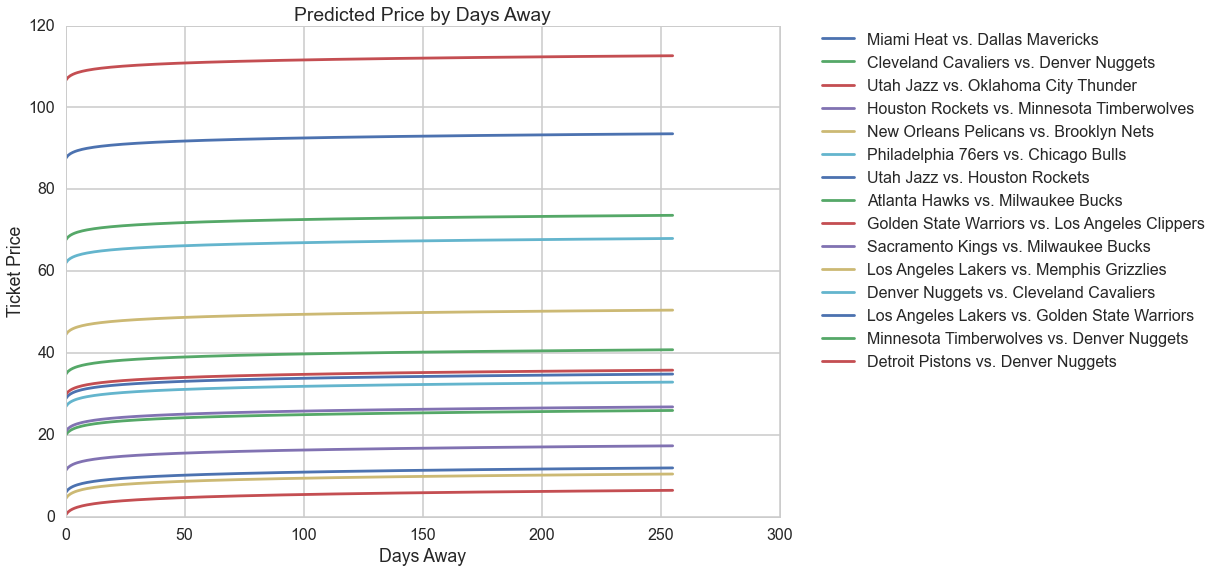

In [172]:
numtoplot = 15
samp = np.random.choice(a = range(0, len(regdf.index)), size = numtoplot, replace = False)
for i in samp:
    viewdaysaway(i, clflassofull)
plt.show
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# sources: http://matplotlib.org/users/legend_guide.html#legend-location

***We make the same plot for the top-ranked team in the league, the Golden State Warriors. We see the same trend (this is known by the fact that the coefficient ought to be constant by the model statement). Interestingly, we see that tickets tend to be expected in the 80-100 dollar range.***

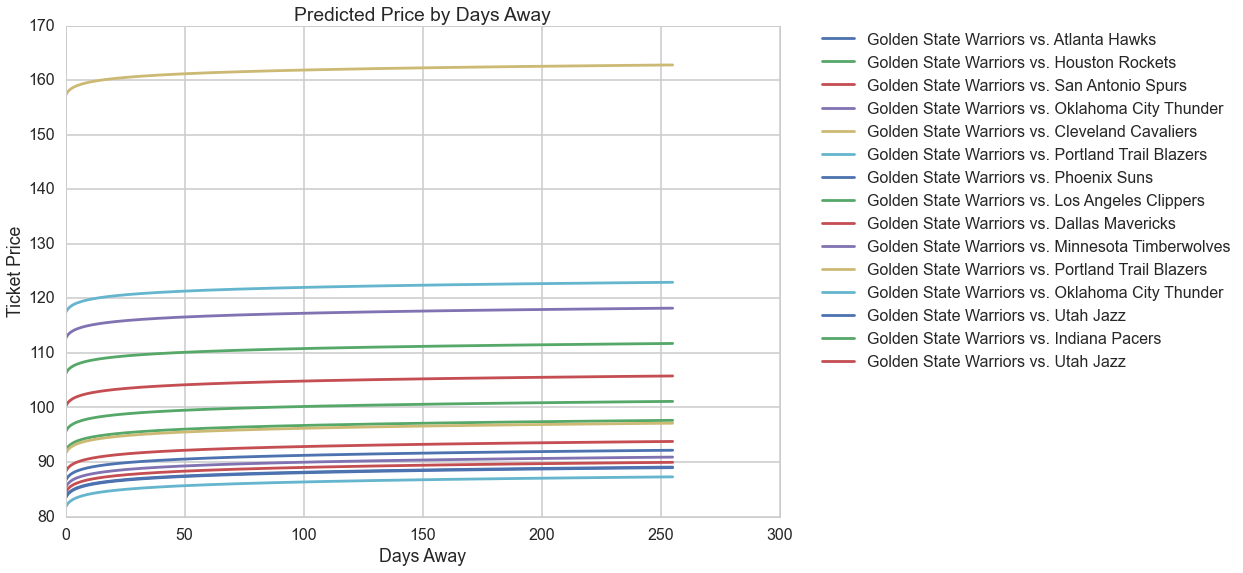

In [440]:
numtoplot = 15

gamesfromtoprankedteam = regdf.loc[regdf.rankNBA_home == 1].index.values
samp = np.random.choice(a = gamesfromtoprankedteam, size = numtoplot, replace = False)

for i in samp:
    viewdaysaway(i, clflassofull)
plt.show
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# sources: http://matplotlib.org/users/legend_guide.html#legend-location

***We make the same plot for the bottom-ranked team in the league, the Philadelphia 76ers. We see the same trend (this is known by the fact that the coefficient ought to be constant by the model statement). Interestingly, we see that tickets tend to be expected in the 0-15 dollar range. It makes sense that they would be lower than those for the Golden State Warriors, which is a good sign for our model. The model, like many linear models, has a major flaw, in that it can predict ticket prices less than 0 (as below).***

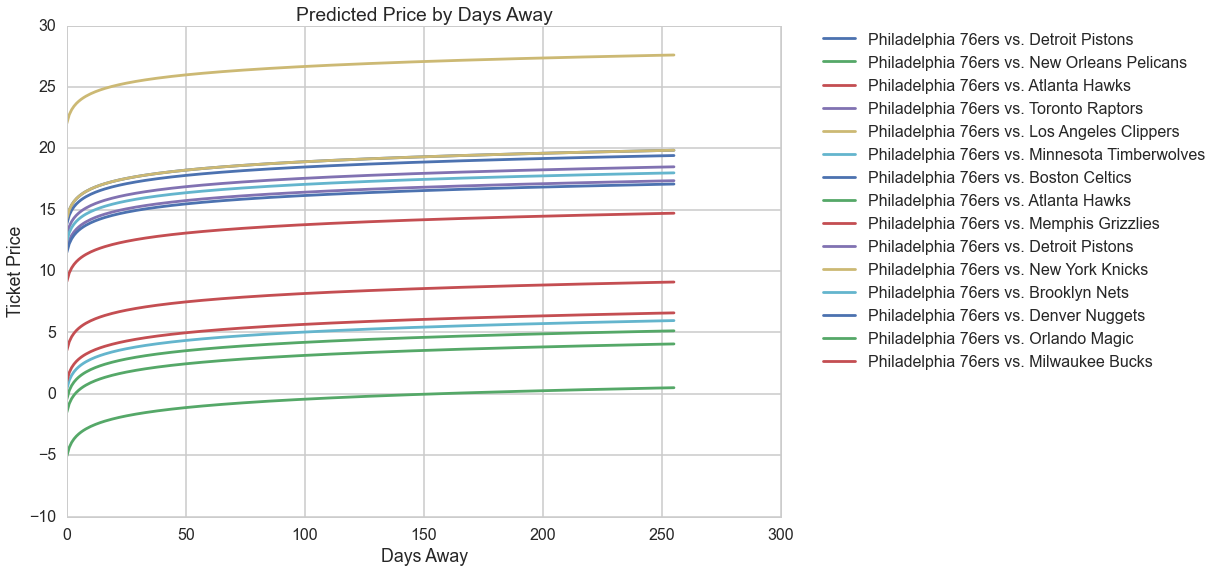

In [441]:
numtoplot = 15

gamesfrombottomrankedteam = regdf.loc[regdf.rankNBA_home == 30].index
samp = np.random.choice(a = gamesfrombottomrankedteam, size = numtoplot, replace = False)

for i in samp:
    viewdaysaway(i, clflassofull)
plt.show
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# sources: http://matplotlib.org/users/legend_guide.html#legend-location

***As we can see here, we can extend our analysis, by assuming that other predictors remain constant, to make predictions beyond the time horizon during which we could download data.***

##b. Check These Predictions Against Data from One Week in the Future, as in Part 2

We check these predictions against the test set used for the model of the price a week ahead in Part 2 so that the results are comparable between models. Again, we compare to the baseline of simply using today's price to predict next week's price.

In [367]:
# make a df with daysaway subtracted by 7 for games more than 7 days away
# use the dataframe from above, as it has the same games, but includes future prices
shiftdaysdf = regdfweek

# drop prices on the day of the game, as those are unreliable and depended on download time
shiftdaysdf = shiftdaysdf.loc[shiftdaysdf['daysaway'] > 7]
temp = shiftdaysdf["daysaway"].values - 7
shiftdaysdf["newdaysaway"] = temp

shiftdaysdf.rename(columns={'daysaway': 'old'}, inplace=True)
shiftdaysdf.rename(columns={'newdaysaway': 'daysaway'}, inplace=True)
shiftdaysdf.rename(columns={'lowest_price_good_ago': 'lowest_price_good'}, inplace=True)

shiftdaysdf = shiftdaysdf.reset_index()
futprice = shiftdaysdf["lowest_price_good_now"]


/Users/walkerevans/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [439]:
# make predictions
forpredalldatafut = pd.DataFrame(shiftdaysdf.lowest_price_good)
for xvar in xvarsintuitive:
    forpredalldatafut[xvar] = shiftdaysdf[xvar]
predydatafut,predxdatafut = patsy.dmatrices(formulaintuitive, data=forpredalldatafut)

preds = clflassofull.predict(predxdatafut)
predsbaseline = shiftdaysdf["lowest_price_good"]
trues = futprice

# errors
prederrors = []
prederrorsfutpred = prederrors
baselineerrors = []
count = 0
for act in futprice:
    prederrors.append(float(preds[count] - act))
    baselineerrors.append(float(predsbaseline[count] - act))
    count = count + 1

# use errors that are from the same games as the ones in the test set (testidsweek) for the other model so can compare
temp = pd.DataFrame()
temp["error"] = prederrors
temp["id"] = shiftdaysdf["id"]
prederrorslocs = temp.index[shiftdaysdf["id"].isin(testidsweek)]
prederrors = temp.loc[prederrorslocs,"error"]

temp = pd.DataFrame()
temp["error"] = baselineerrors
temp["id"] = shiftdaysdf["id"]
baselineerrorslocs = temp.index[shiftdaysdf["id"].isin(testidsweek)]
baselineerrors = temp.loc[baselineerrorslocs,"error"]

# stats on validation set
statstablefutpred = pd.DataFrame()
statstablefutpred["Lasso Model on Today Future Pred Accuracy"] = [round(np.sqrt(np.mean(squarelist(prederrors))),2), round(np.mean(abslist(prederrors)),2)]
statstablefutpred["Baseline Future Pred Accuracy"] = [round(np.sqrt(np.mean(squarelist(baselineerrors))),2), round(np.mean(abslist(baselineerrors)),2)]
statstablefutpred.index = ["RMSE","MAD"]
statstablefutpred

Lasso Model on Today Future Pred Accuracy  Baseline Future Pred Accuracy
RMSE                                      19.04                          10.41
MAD                                        8.56                           3.94

***We see that our model predicts far worse than the baseline of simply using today's price. These results can be seen in the sample of predictions plotted below. The plots below suggest that the model does a very poor of job of predicting when the price does not change much over the next week, which makes a good deal of sense given that it never uses today's price as a predictor. Also, it assumes that the other predictors remain constant. Overall, it seems to OVERestimate the change over the next week. While it does not appear to do an excellent job of predicting one day ahead, it is important to keep in mind that this model is most useful in its ability to make predictions over ANY time horizons, which the model in part 2. could not do.***

Examine a few predictions:

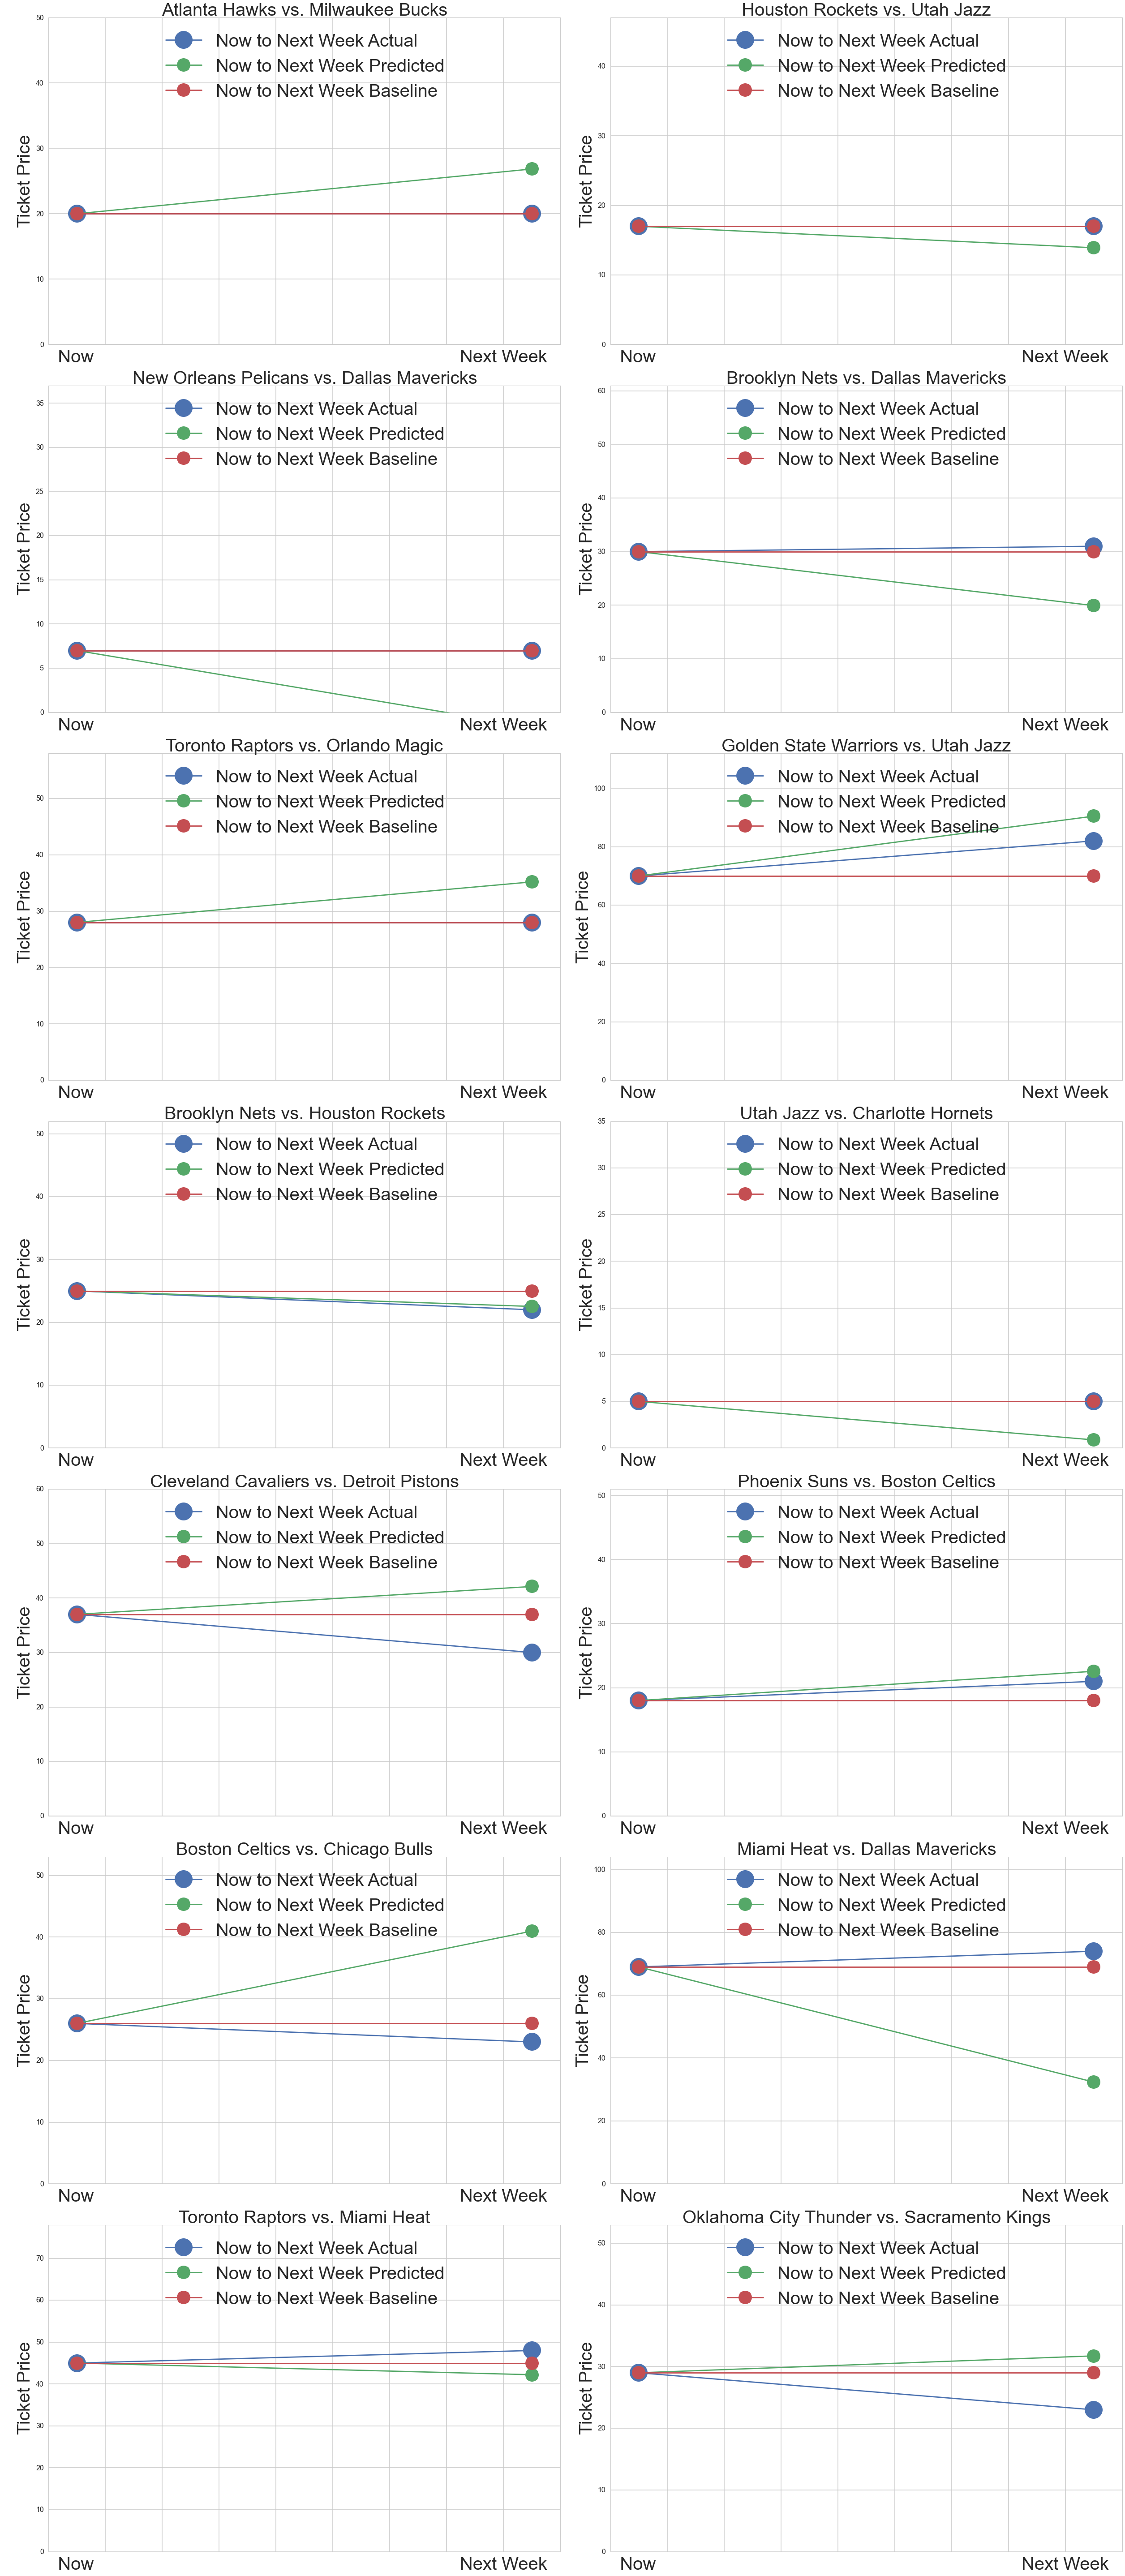

In [200]:
# data for plot function
actualnextweek = predsbaseline
actuallastweek = trues
data = shiftdaysdf
predicted = preds

plotpred(actualnextweek, actuallastweek, predicted, data)

***We again examine the prediction erros over days away and colored by home team rank (which is analogous to team). We see that again, the model underestimates the price a week ahead for games in the near future. There does not appear to be any trend in the colors, which suggests no systematic problem by team. The size of some of the errors is very notable (in the realm of 75 or -130 dollars).***

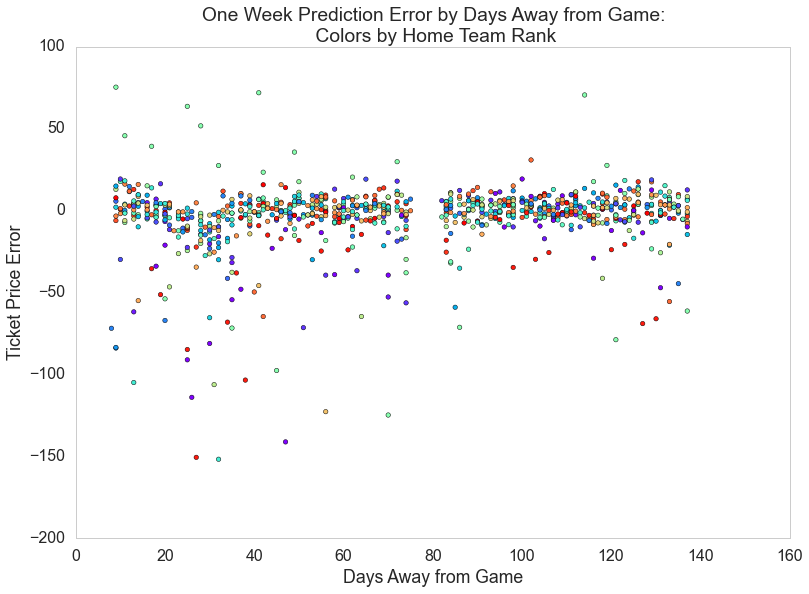

In [201]:
errorsplot(shiftdaysdf.daysaway+7, prederrorsfutpred, shiftdaysdf.rankNBA_home)

# 5. Final Thoughts on Future Prediction

Finally, we compare the results from our model of next week's price to predictions from our model of today's price.

##a. Compare Use of Model on Today's Price and Model on Next Week's Price as Tools for Future Prediction

In [374]:
print "Prediction Accuracy Using Today Model to Forecast One Week Forward:"
statstablefutpred

Prediction Accuracy Using Today Model to Forecast One Week Forward:


Lasso Model on Today Future Pred Accuracy  Baseline Future Pred Accuracy
RMSE                                      19.15                          10.41
MAD                                        8.54                           3.94

In [376]:
print "Prediction Accuracy Using Future Model to Forecast One Week Forward:"
statstableweek

Prediction Accuracy Using Future Model to Forecast One Week Forward:


One Week Lasso Accuracy  Baseline Accuracy
RMSE                     7.31              10.41
MAD                      3.80               3.94

RMSE Comparison:


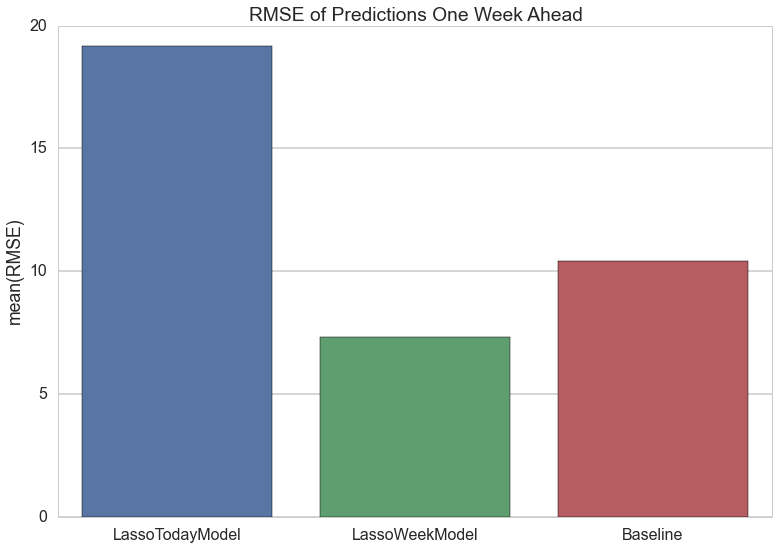

In [438]:
#RMSEs
RMSE = pd.DataFrame()
lst = [statstablefutpred.iloc[0,0], statstableweek.iloc[0,0], statstableweek.iloc[0,1]]
RMSE["RMSE"] = lst
RMSE.index = ["LassoTodayModel","LassoWeekModel","Baseline"]
digits = ["LassoTodayModel","LassoWeekModel","Baseline"]
print "RMSE Comparison:"
ax = plt.axes()
sns.barplot(y = "RMSE",x = digits, data = RMSE)
ax.set_title('RMSE of Predictions One Week Ahead')
plt.show()

# sources: http://stackoverflow.com/questions/32723798/how-do-i-add-a-title-to-seaborn-heatmap

MAD Comparison:


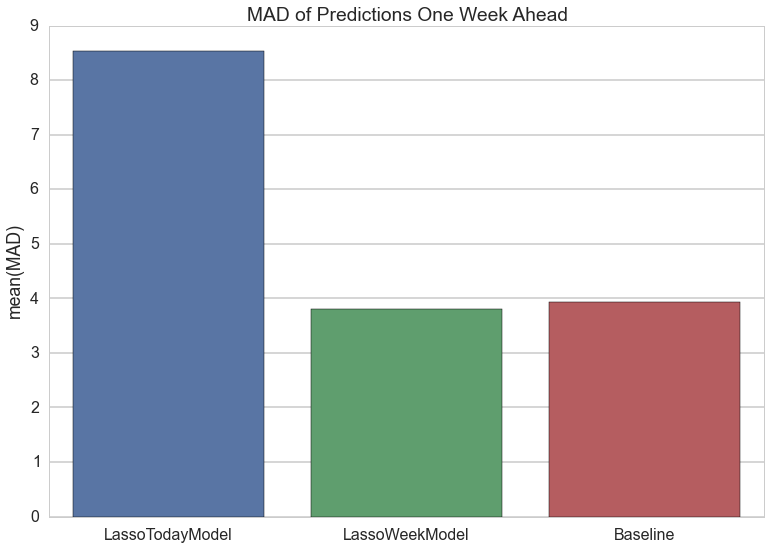

In [436]:
#MADs
MAD = pd.DataFrame()
lst = [statstablefutpred.iloc[1,0], statstableweek.iloc[1,0], statstableweek.iloc[1,1]]
MAD["MAD"] = lst
MAD.index = ["LassoTodayModel","LassoWeekModel","Baseline"]
digits = ["LassoTodayModel","LassoWeekModel","Baseline"]
print "MAD Comparison:"
ax = plt.axes()
sns.barplot(y = "MAD",x = digits, data = MAD)
ax.set_title('MAD of Predictions One Week Ahead')
plt.show()

***Above, we can see clearly that the Lasso Model for next week's price is best. It beats the baseline of using today's price as the prediction for next week and by far beats the use of the model on today's price for prediction. This model performs well for prediction of next week's price and by the large success in RMSE it has fewer LARGE errors than the baseline. Again, it must be noted that while the model of today's price did not perform well on the price in one week, it is useful in its ability to predict over any time horizon.***

***In terms of quantifying the effect of the number of days away from a game on the minimum ticket price, we saw two different results. The model on next week's price predicted a rise in price as a game approaches, but the model on today's price predicted a drop. Because of the significantly better predictive ability of the model on next week's price, we tend to believe its result that one should *buy early* to save money.***